<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Perceptron-loss-function" data-toc-modified-id="Perceptron-loss-function-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Perceptron loss function</a></span><ul class="toc-item"><li><span><a href="#Discussion:-What-can-go-wrong-with-the-max-cost-loss-function?" data-toc-modified-id="Discussion:-What-can-go-wrong-with-the-max-cost-loss-function?-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Discussion: What can go wrong with the max cost loss function?</a></span></li><li><span><a href="#The-perceptron-as-a-neural-network" data-toc-modified-id="The-perceptron-as-a-neural-network-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>The perceptron as a neural network</a></span></li></ul></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Exercise:-Compare-the-loss-function-for-the-perceptron-and-logistic-regression-after-optimization-for-the-&quot;blobs&quot;-and-&quot;moons&quot;-datasets." data-toc-modified-id="Exercise:-Compare-the-loss-function-for-the-perceptron-and-logistic-regression-after-optimization-for-the-&quot;blobs&quot;-and-&quot;moons&quot;-datasets.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Exercise: Compare the loss function for the perceptron and logistic regression after optimization for the "blobs" and "moons" datasets.</a></span></li></ul></li><li><span><a href="#Margin-loss-function" data-toc-modified-id="Margin-loss-function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Margin loss function</a></span><ul class="toc-item"><li><span><a href="#Discussion:-Which-of-these-models-is-the-best?" data-toc-modified-id="Discussion:-Which-of-these-models-is-the-best?-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discussion: Which of these models is the best?</a></span></li></ul></li><li><span><a href="#Counting-loss-function" data-toc-modified-id="Counting-loss-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Counting loss function</a></span><ul class="toc-item"><li><span><a href="#Discussion:-How-will-the-different-cost-functions-respond-to-outliers?" data-toc-modified-id="Discussion:-How-will-the-different-cost-functions-respond-to-outliers?-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Discussion: How will the different cost functions respond to outliers?</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

In [2]:
import numpy as np
import pandas as pd

clrs = np.array(['#003057', '#EAAA00', '#4B8B9B', '#B3A369', '#377117', '#1879DB', '#8E8B76', '#F5D580', '#002233'])

# Generalized Linear Models

In this lecture we will explore a type of discriminative classification model called "generalized linear models". This is slightly different from the "general linear model" we discussed for regression, but there are also some similarities.

Recall the general form of a linear model:

$y_i = \sum_j w_j X_{ij} + \epsilon_i$

or

$\vec{y} = \bar{\bar{X}}\vec{w} + \vec{\epsilon}$

In the case of a "general linear model", we assume that the error, $\vec{\epsilon}$, follows a normal distribution. However, in a generalized linear model the error follows other types of distributions. This is handled by taking a non-linear tranform:

$\vec{y_{GLM}} = \sigma(\bar{\bar{X}}\vec{w}) + \sigma(\vec{\epsilon})$

where $\sigma(\vec{z})$ is a non-linear function that "links" the normal distribution to the distribution of interest. These "link functions" can be derived from probability theory, but we will derive them from the loss function perspective.

## Perceptron loss function

Recall the derivation of the "perceptron" loss function from the last lecture. We start with a model that discriminates between two classes:

$\bar{\bar{X}}\vec{w} > 0$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} < 0$ if $y_i=-1$ (class 2)

Then multiply by $y_i$ to form a single inequality:

$-y_i \bar{\bar{X}}\vec{w} < 0$

and take the maximum to create an equality:

$max(0, -y_i \bar{\bar{X}}\vec{w}) = 0$

We will apply this to the toy datasets:

/Users/aj/anaconda3/envs/OSI/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


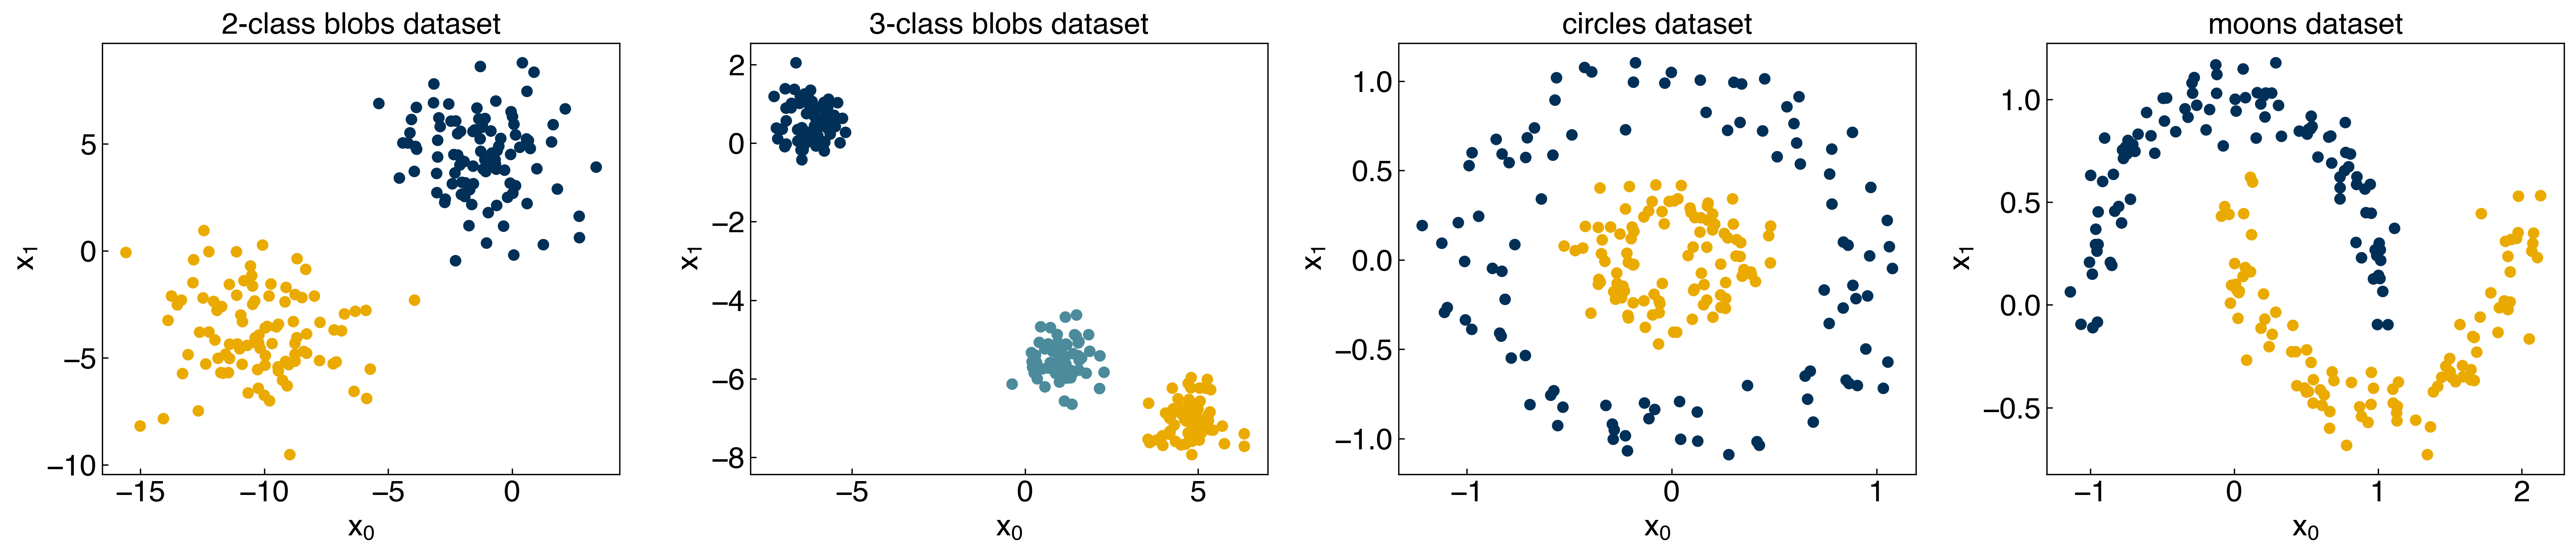

In [3]:
from sklearn.datasets.samples_generator import make_blobs, make_moons, make_circles
np.random.seed(1) #make sure the same random samples are generated each time

noisiness = 1

X_blob, y_blob = make_blobs(n_samples=200, centers=2, cluster_std=2*noisiness, n_features=2)

X_mc, y_mc = make_blobs(n_samples=200, centers=3, cluster_std=0.5*noisiness, n_features=2)

X_circles, y_circles = make_circles(n_samples=200, factor=0.3, noise=0.1*noisiness)

X_moons, y_moons = make_moons(n_samples=200, noise=0.1*noisiness)

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

all_datasets = [[X_blob, y_blob], [X_mc, y_mc], [X_circles, y_circles], [X_moons, y_moons]]
titles = ['2-class blobs dataset', '3-class blobs dataset', 'circles dataset', 'moons dataset']

for i, Xy_i in enumerate(all_datasets):
    Xi, yi = Xy_i
    axes[i].scatter(Xi[:,0], Xi[:,1], c = clrs[yi])
    axes[i].set_xlabel('$x_0$')
    axes[i].set_ylabel('$x_1$')
    axes[i].set_title(titles[i])
    
plt.show()

We can implement the model:

In [4]:
def add_intercept(X):
    intercept = np.ones((X.shape[0],1))
    X_intercept = np.append(intercept,X,1)
    return X_intercept

def linear_classifier(X, w):
    X_intercept = add_intercept(X)
    p = np.dot(X_intercept, w)
    return p > 0

However, before applying the model, we need to "re-scale" the class data to fit the assumption we made. By default, `scikit-learn` uses $y=0$ and $y=1$ to define the two different classes. However, when we derived the loss function we assumed that the classes were defined by $y=1$ and $y=-1$, with the discrimination line at $y=0$.

Text(0.5, 1.0, 'Re-scaled Class Definitions')

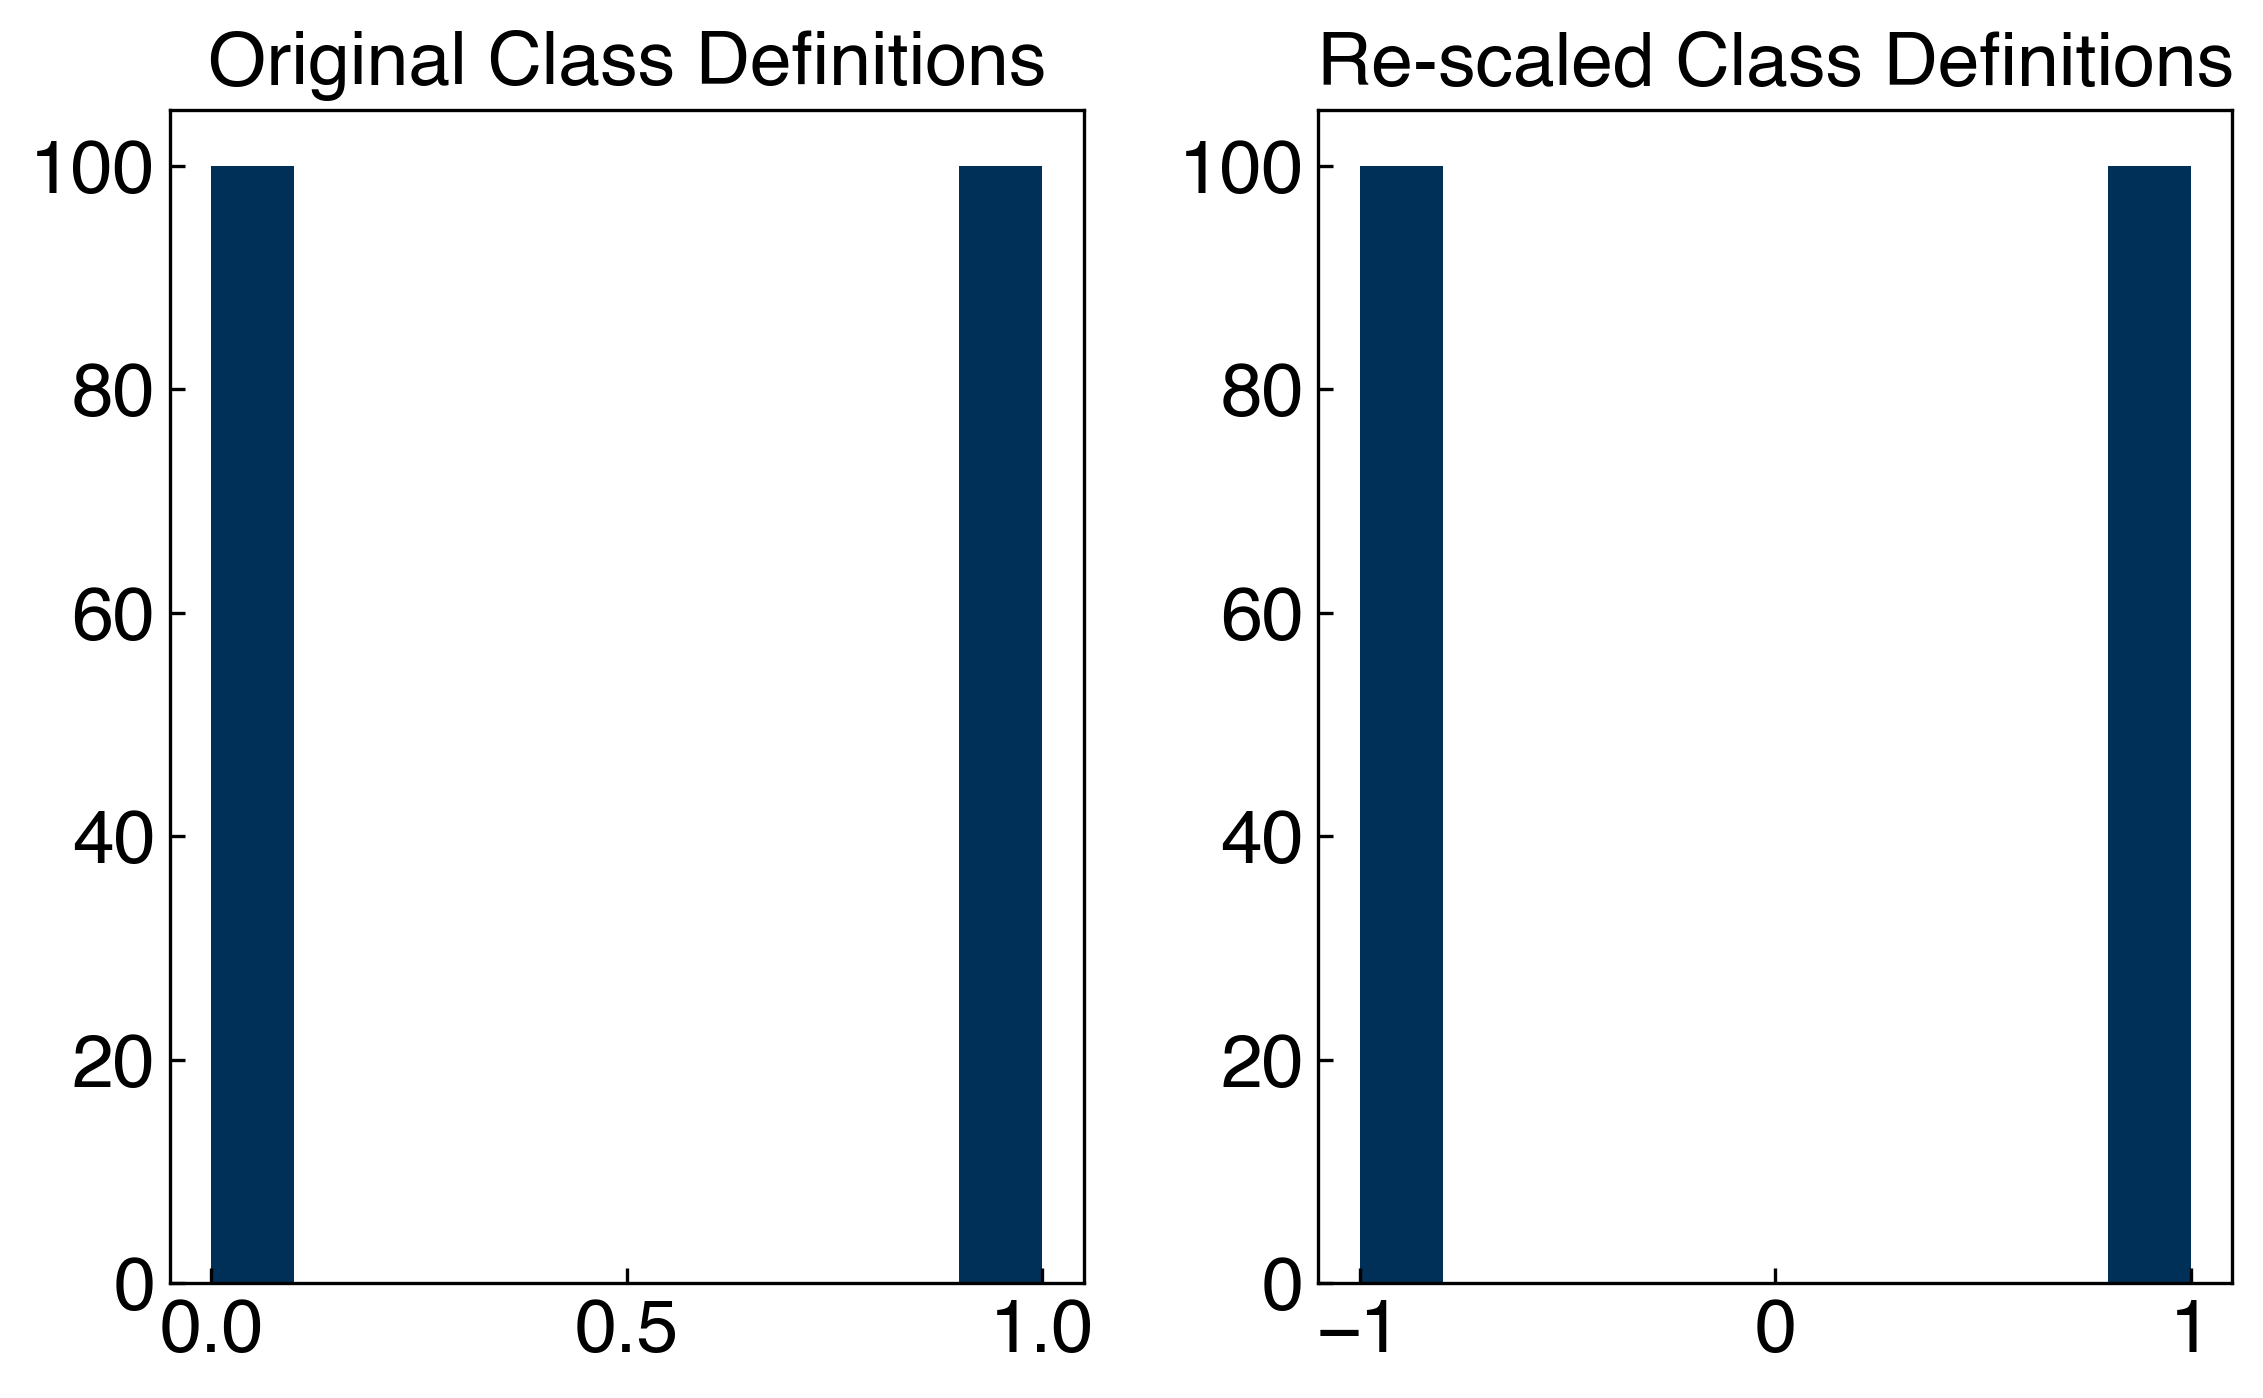

In [5]:
fig, axes = plt.subplots(1,2, figsize=(8,5))

X = X_blob
y = y_blob
axes[0].hist(y)
axes[0].set_title('Original Class Definitions')
y = y_blob*2 - 1 #convert to -1, 1
axes[1].hist(y)
axes[1].set_title('Re-scaled Class Definitions')

Note that this re-scaling is only necessary if we are using our own model. The `scikit-learn` implementation is clever enough to take care of this automatically.

Now we can select some arbitrary parameters and evaluate the model:

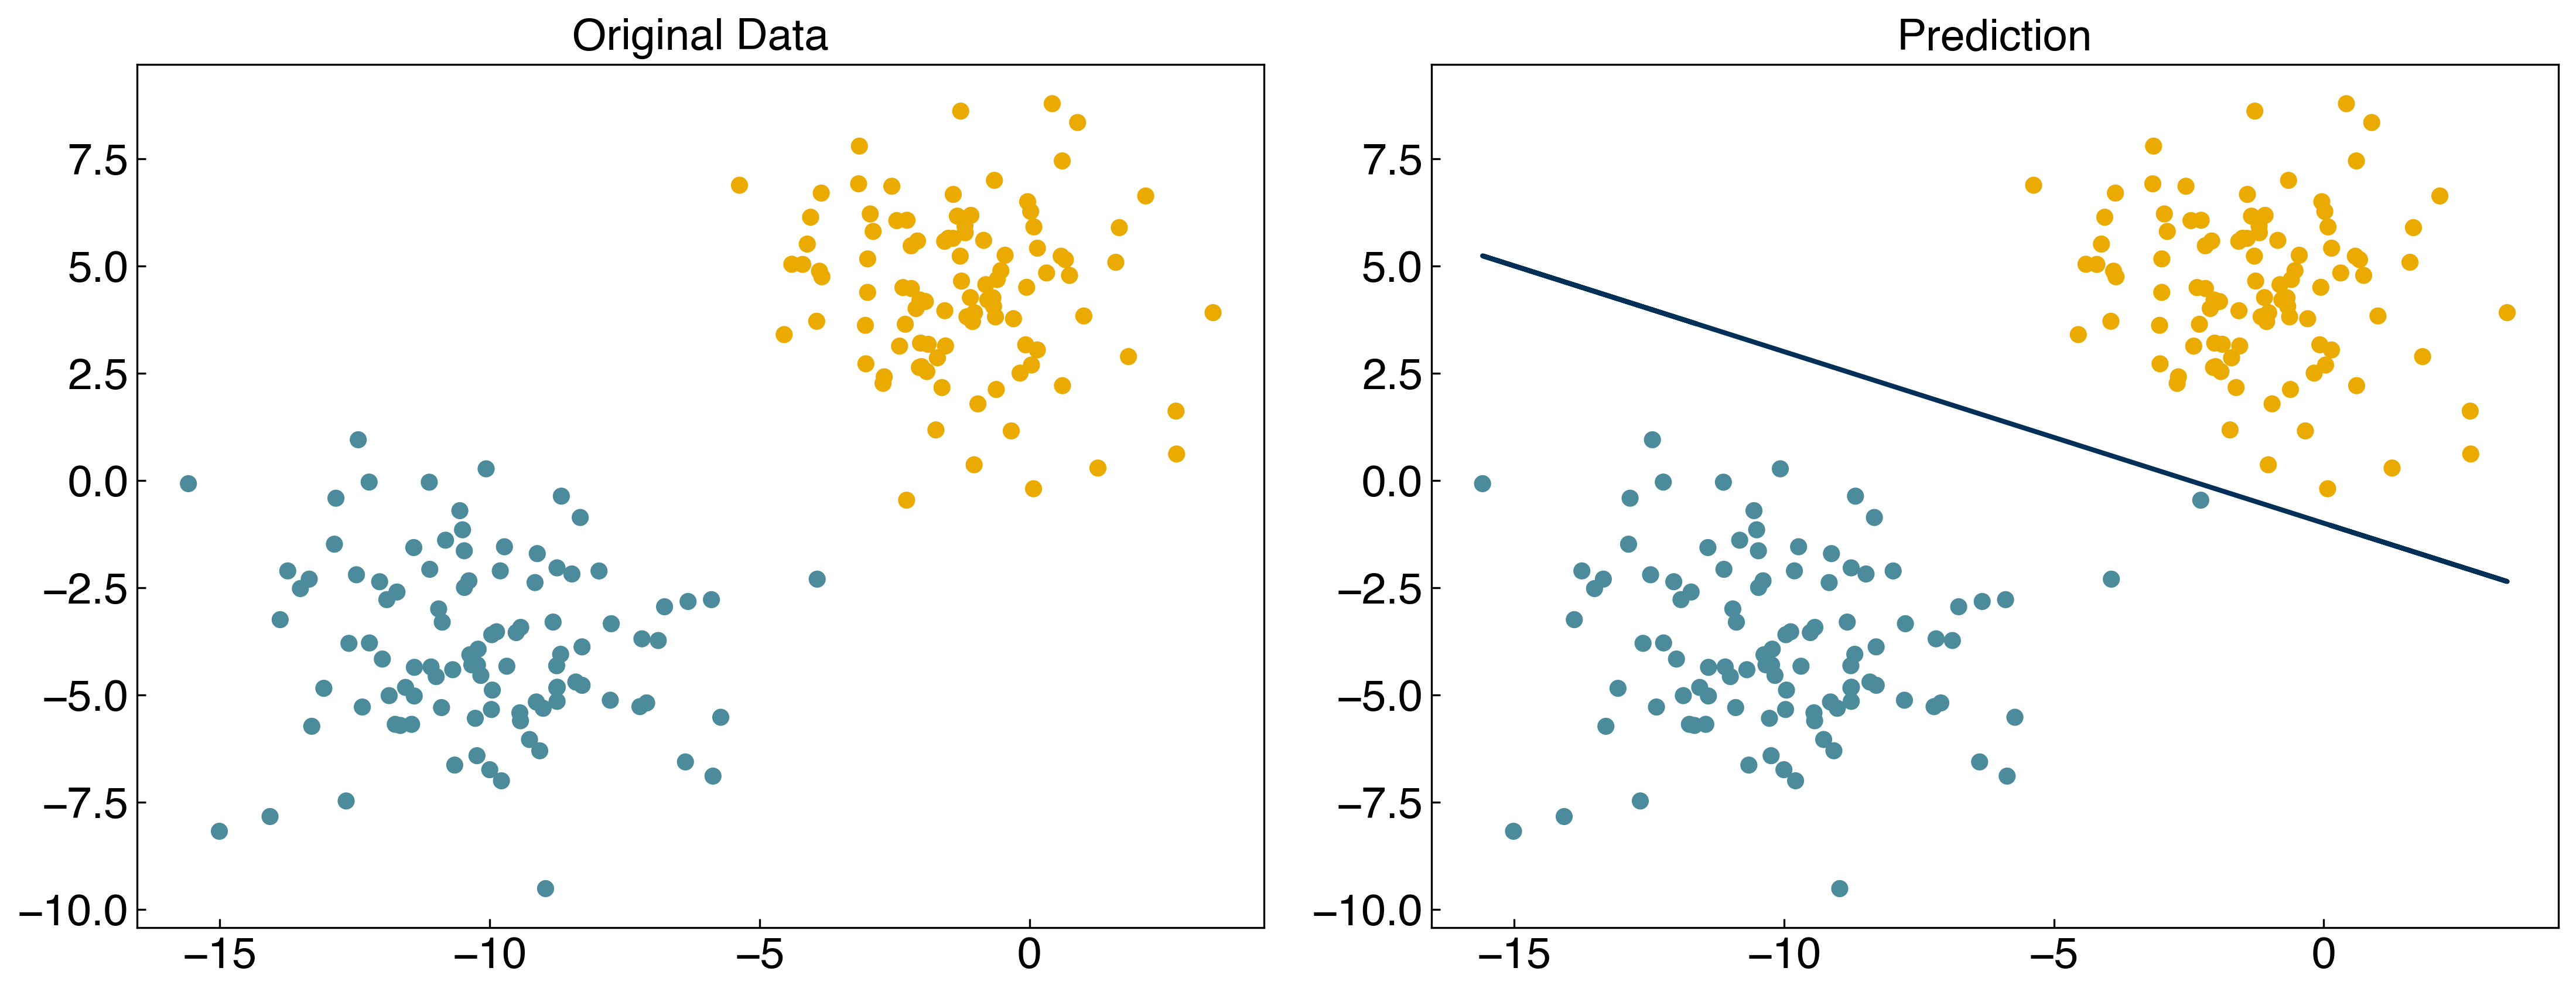

In [6]:
w = np.array([-10, -4, -10])
prediction = linear_classifier(X, w)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w[1] / w[2]
b = -w[0] / w[2]
axes[1].plot(X[:, 0], m*X[:, 0]+b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

and we can implement the max cost loss function to compute the cost of a given set of parameters:

In [7]:
def max_cost(w, X=X, y=y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,w)
    return sum(np.maximum(0, -y*Xb))

print(max_cost(w,X,y))

3.75103040564972


Now, we can solve the model by minimizing the loss function with respect to the parameters:

In [8]:
from scipy.optimize import minimize

result = minimize(max_cost, w)
w_perceptron = result.x
result

      fun: 0.0
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([0., 0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 1
     njev: 4
   status: 0
  success: True
        x: array([-10.69214391,  -2.42205481,  -9.67940886])

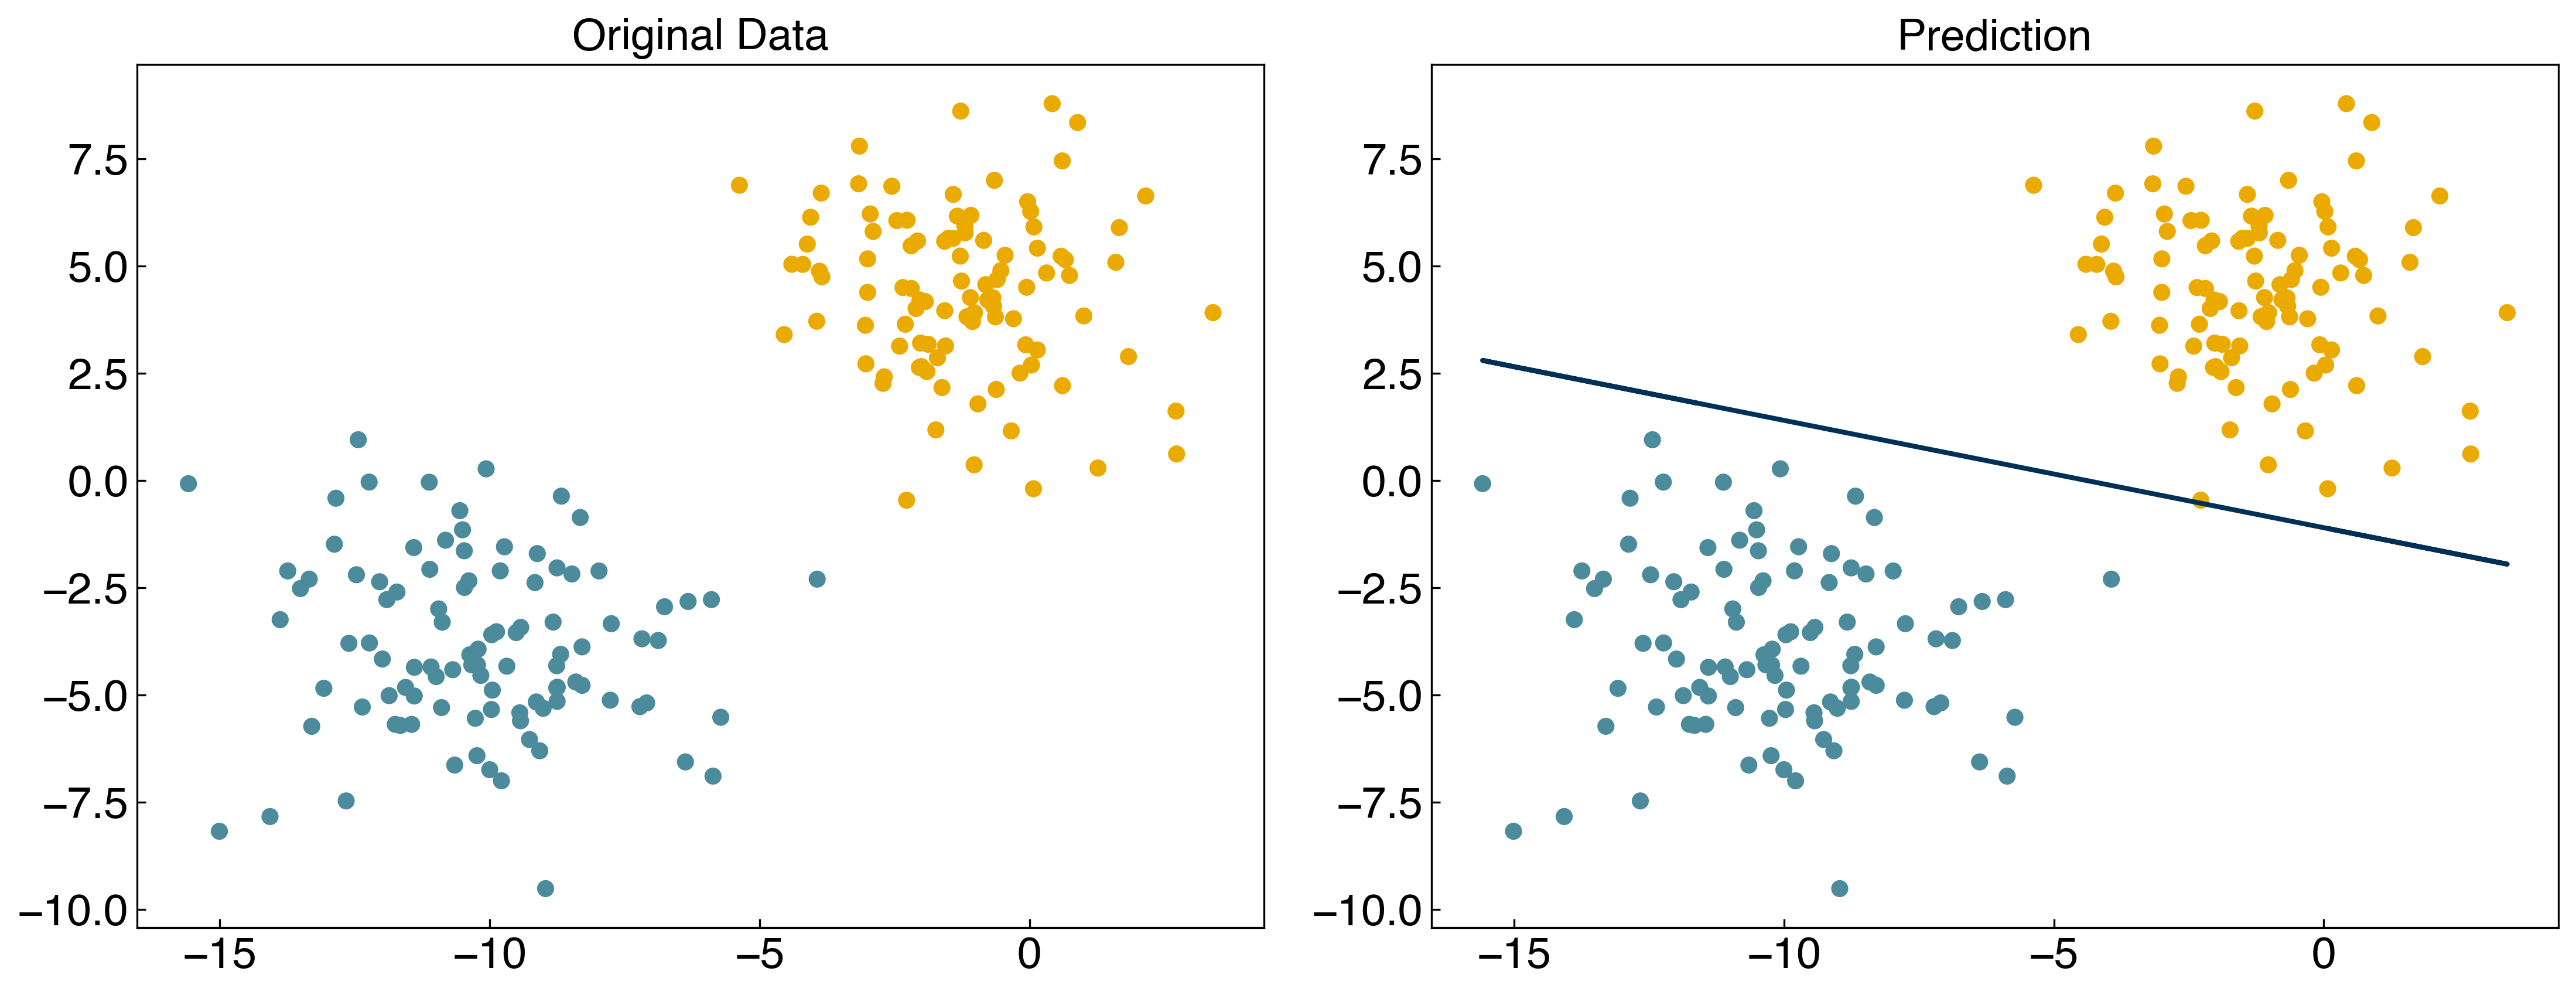

In [9]:
prediction = linear_classifier(X, w_perceptron)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w_perceptron[1] / w_perceptron[2]
b = -w_perceptron[0] / w_perceptron[2]
axes[1].plot(X[:, 0], m*X[:, 0] + b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

### Discussion: What can go wrong with the max cost loss function?

> - The first derivative of the max cost loss function is non differentiable.  
> - An initial guess of $\vec{0}$ makes the max cost zero, which is a trivial solution.

### The perceptron as a neural network

It turns out that the "perceptron", invented by Frank Rosenblatt in 1958, was the original neural network. The structure of the perceptron is similar to a biological neuron which "fires" if the sum of its inputs exceed some threshold:

<center>
<img src="images/perceptron_NN.png" width="400">
</center>

The "perceptron" is equivalent to a "single layer" neural network with a step activation function. In fact, all the generalized linear models for classification are single layer neural networks, but with slightly different types of activation functions.

## Logistic regression

The max cost loss function has two main problems:

(1) There is a trivial solution at $\vec{w} = 0$.

(2) The $max$ function is not differentiable.

We can overcome the second problem by creating some smooth approximation of the maximum function. This is achieved using the "softmax" function:

$max(x,y) \approx soft(x,y) = log(exp(x) + exp(y))$

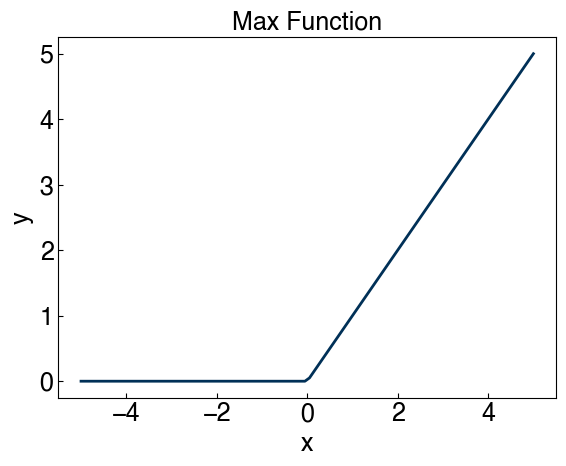

In [10]:
x = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize = (6, 5), dpi = 100)

ax.plot(x, np.maximum(0, x), ls = '-')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Max Function');

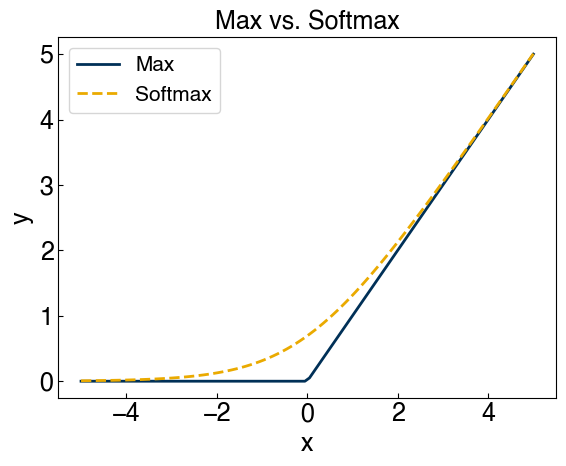

In [11]:
x = np.linspace(-5, 5, 100)

fig, ax = plt.subplots(figsize = (6, 5), dpi = 100)

ax.plot(x, np.maximum(0, x), ls = '-')
ax.plot(x, np.log(np.exp(0) + np.exp(x)), ls = '--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(['Max', 'Softmax'])
ax.set_title('Max vs. Softmax');

We can see that this also gets rid of the "trivial solution" at $\vec{w}=0$, so our problems are solved!

Now we can write a "softmax" cost function:

$g_{softmax}(\vec{w}) = \sum_i log\left\{1 + exp(-y_i \bar{\bar{X}}\vec{w})\right\}$

Let's implement it:

In [12]:
def softmax_cost(w, X = X, y = y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    exp_yXb = np.exp(-y * Xb)
    return sum(np.log(1 + exp_yXb))

print(softmax_cost(w, X, y))

3.7745706457998764


This function is differentiable, so we can minimize this with respect to $\vec{w}$ by setting the derivative equal to zero and solving for $\vec{w}$:

$\frac{\partial g_{softmax}}{\partial \vec{w}} = 0$

It turns out this problem is not linear, and needs to be solved iteratively using e.g. Newton's method. The math is a little more complex than before, so we won't cover it in lecture, but it is covered in Ch. 4 of "Machine Learning Refined" if you are interested. This approximation is called **logistic regression**.

The key concept to understand is that $\vec{w}$ is determined by minimizing the softmax cost function. We can do this numerically for our toy model:

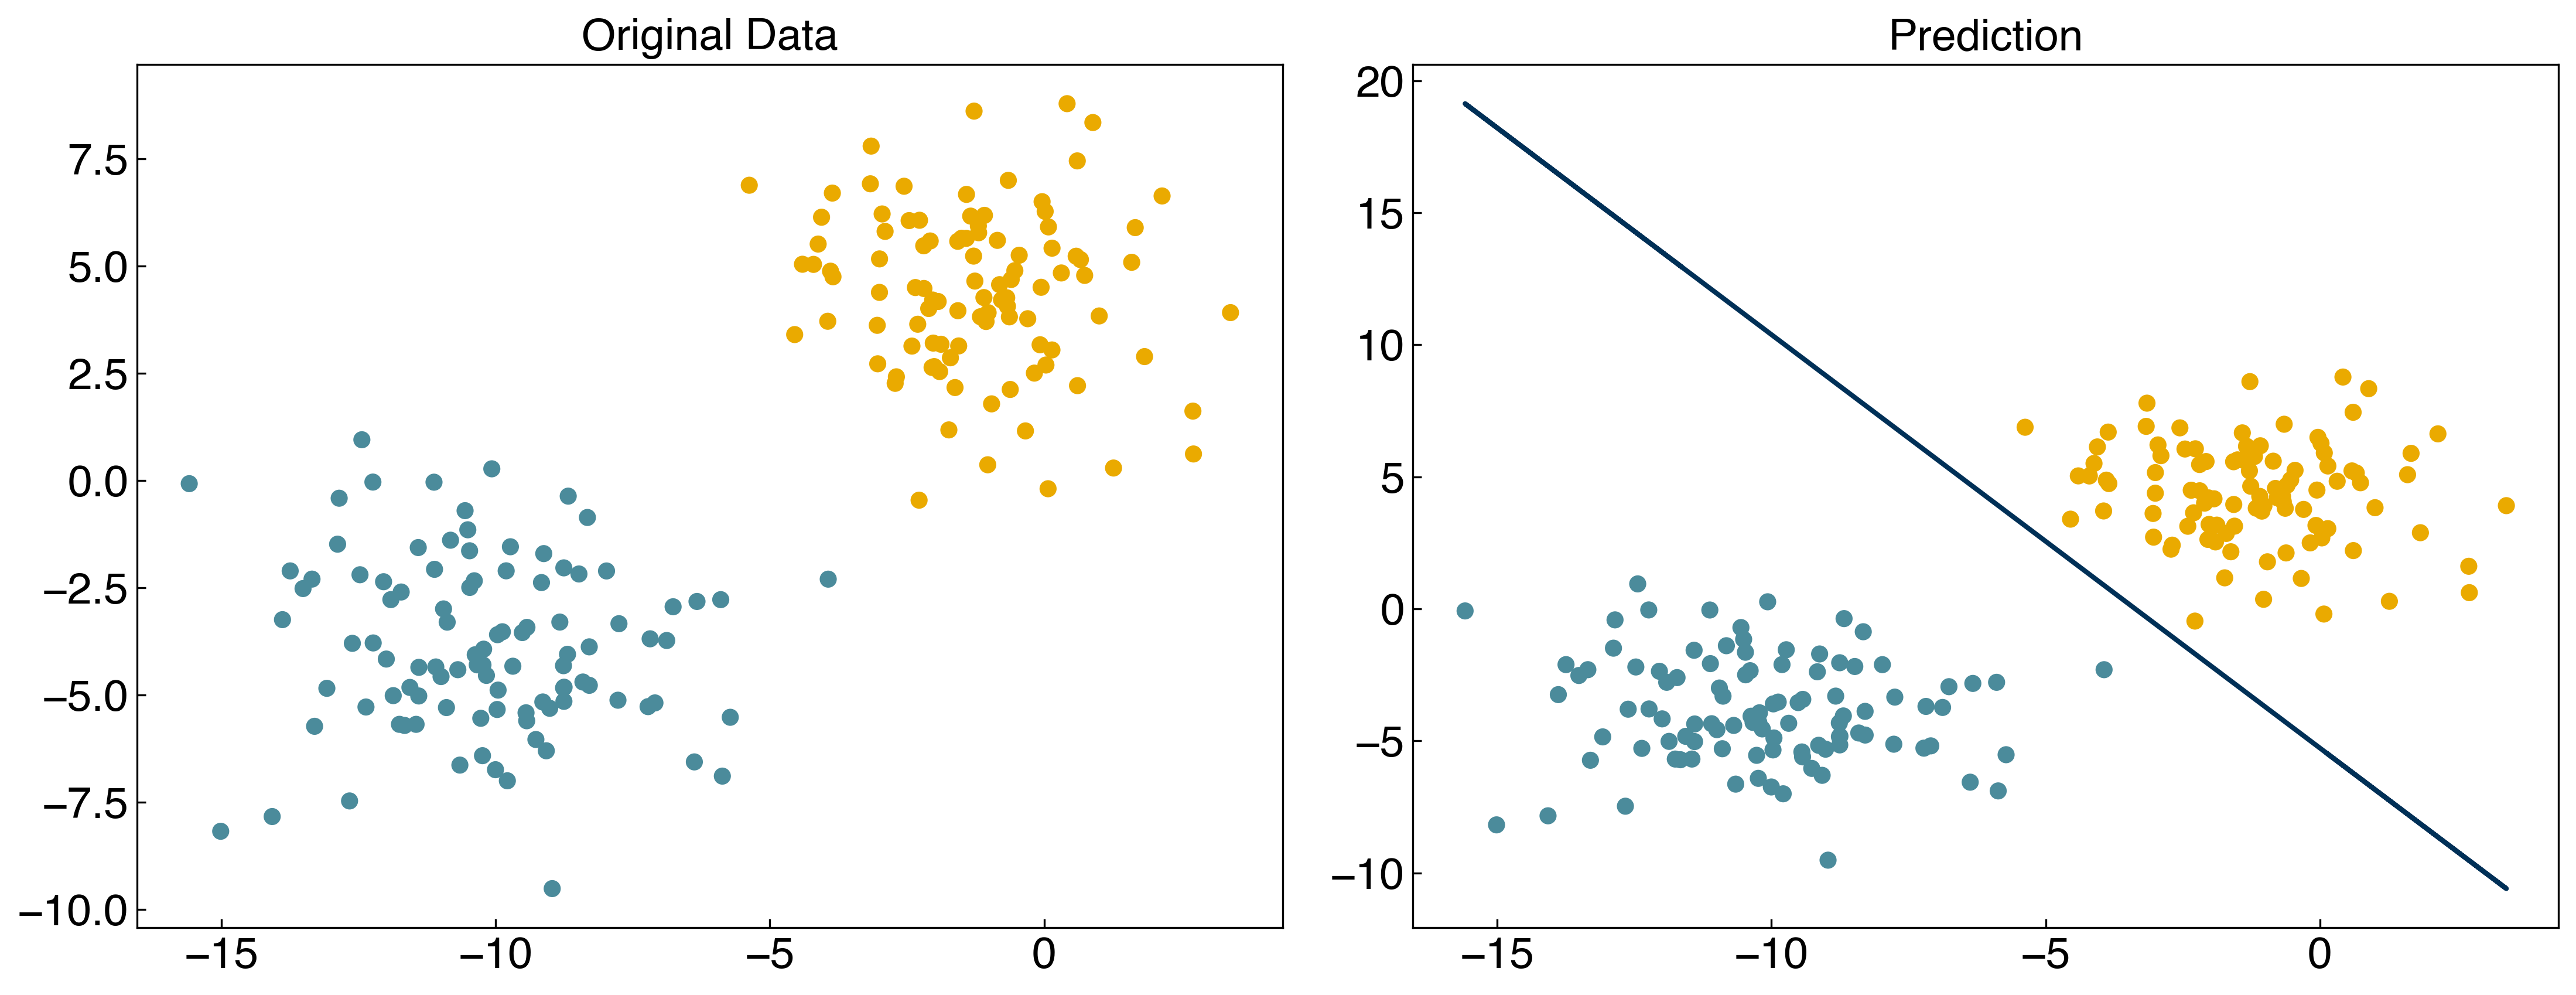

In [13]:
from scipy.optimize import minimize

result = minimize(softmax_cost, w, args = (X, y))
w_logit = result.x

prediction = linear_classifier(X, w_logit)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w_logit[1] / w_logit[2]
b = -w_logit[0] / w_logit[2]
axes[1].plot(X[:, 0], m*X[:, 0] + b, ls = '-')

axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

Note: There are other ways to derive "logistic regression". See Ch. 4 of ML refined for an alternative derivation.

### Exercise: Compare the loss function for the perceptron and logistic regression after optimization for the "moons" dataset.

In [14]:
from scipy.optimize import minimize

y_moons_scaled = 2 * y_moons - 1

w = [-10, 10, 5]

result = minimize(max_cost, w, args = (X_moons, y_moons_scaled))
print('Perceptron loss function: {}'.format(max_cost(result.x, X_moons, y_moons_scaled)))

result = minimize(softmax_cost, w, args = (X_moons, y_moons_scaled))
print('Logistic regression loss function: {}'.format(softmax_cost(result.x, X_moons, y_moons_scaled)))

Perceptron loss function: 4.5796169252392186e-07
Logistic regression loss function: 53.939495485292476


## Margin loss function

Recall the two problems with the max cost function:

1) There is a "trivial solution" at $\vec{w} = 0$

2) The cost function is not differentiable at all points

Logistic regression uses a smooth approximation of the maximum to ensure differentiability, and the "trivial solution" goes away as a side effect.

An alternative approach is to directly eliminate the trivial solution by introducing a "margin" cost function, where we recognize that there will be some "buffer zone" between the classes:

<center>
<img src="images/margin_cost.png" width="500">
</center>

We can write this mathematically as:

$\bar{\bar{X}}\vec{w} \geq 1$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} \leq -1$ if $y_i=-1$ (class 2)

by using the same trick of multiplying by $y_i$ and taking a maximum we can write this as an equality:

$max(0, 1 -y_i \bar{\bar{X}}\vec{w}) = 0$

and the corresponding cost/objective function:

$g_{margin}(\vec{w}) = \sum_i max(0, 1-y_i \bar{\bar{X}}\vec{w})$

Note that this is very similar to the cost function for the perceptron, but now there is no trivial solution at $\vec{w} = 0$. However, we can solve this with a few approaches:

1) Use derivative-free numerical approximations

2) Replax $max$ with a differentiable function like $softmax$ or $max^2$

Let's see what happens with strategy 1:

In [15]:
def margin_cost(w, X = X, y = y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,w)
    return sum(np.maximum(0, 1 - y * Xb))

print(margin_cost(w,X,y))

13950.826906338369


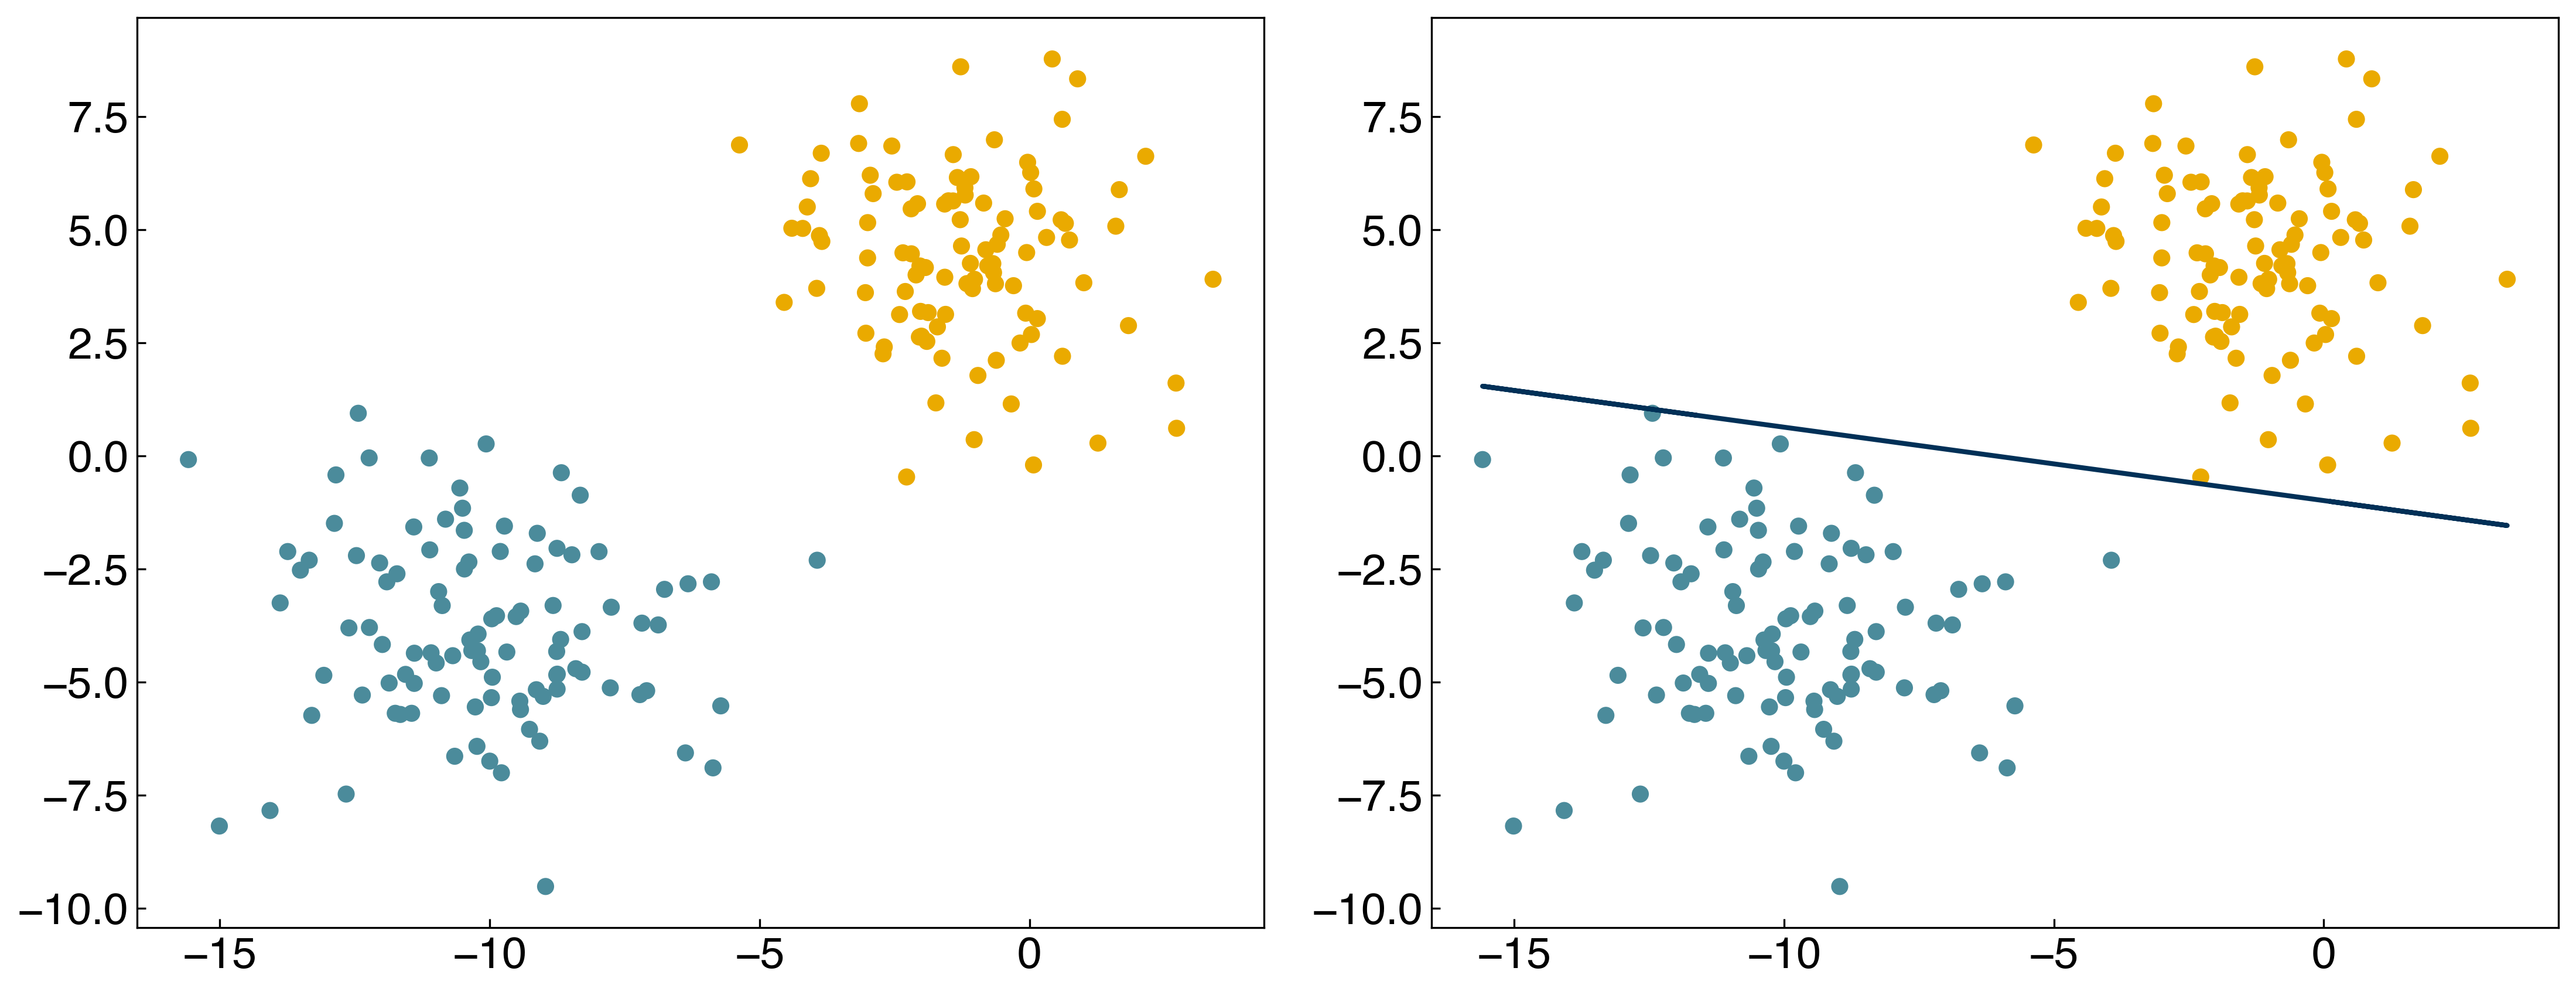

In [16]:
result = minimize(margin_cost, w)

w_opt_margin = result.x

prediction = linear_classifier(X, w_opt_margin)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = - w_opt_margin[1] / w_opt_margin[2]
b = - w_opt_margin[0] / w_opt_margin[2]
axes[1].plot(X[:, 0], m * X[:, 0] + b, ls = '-');

It works, but we get a different solution from logistic regression. Let's see how this compares to the $max^2$ and $softmax$ approximations:

In [17]:
def margin_cost_squared(beta, X = X, y = y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, beta)
    return sum(np.maximum(0, 1 - y * Xb)**2)

def margin_cost_softmax(beta, X = X, y = y):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept,beta)
    exp_yXb = np.exp(1 - y * Xb)
    return sum(np.log(1 + exp_yXb))

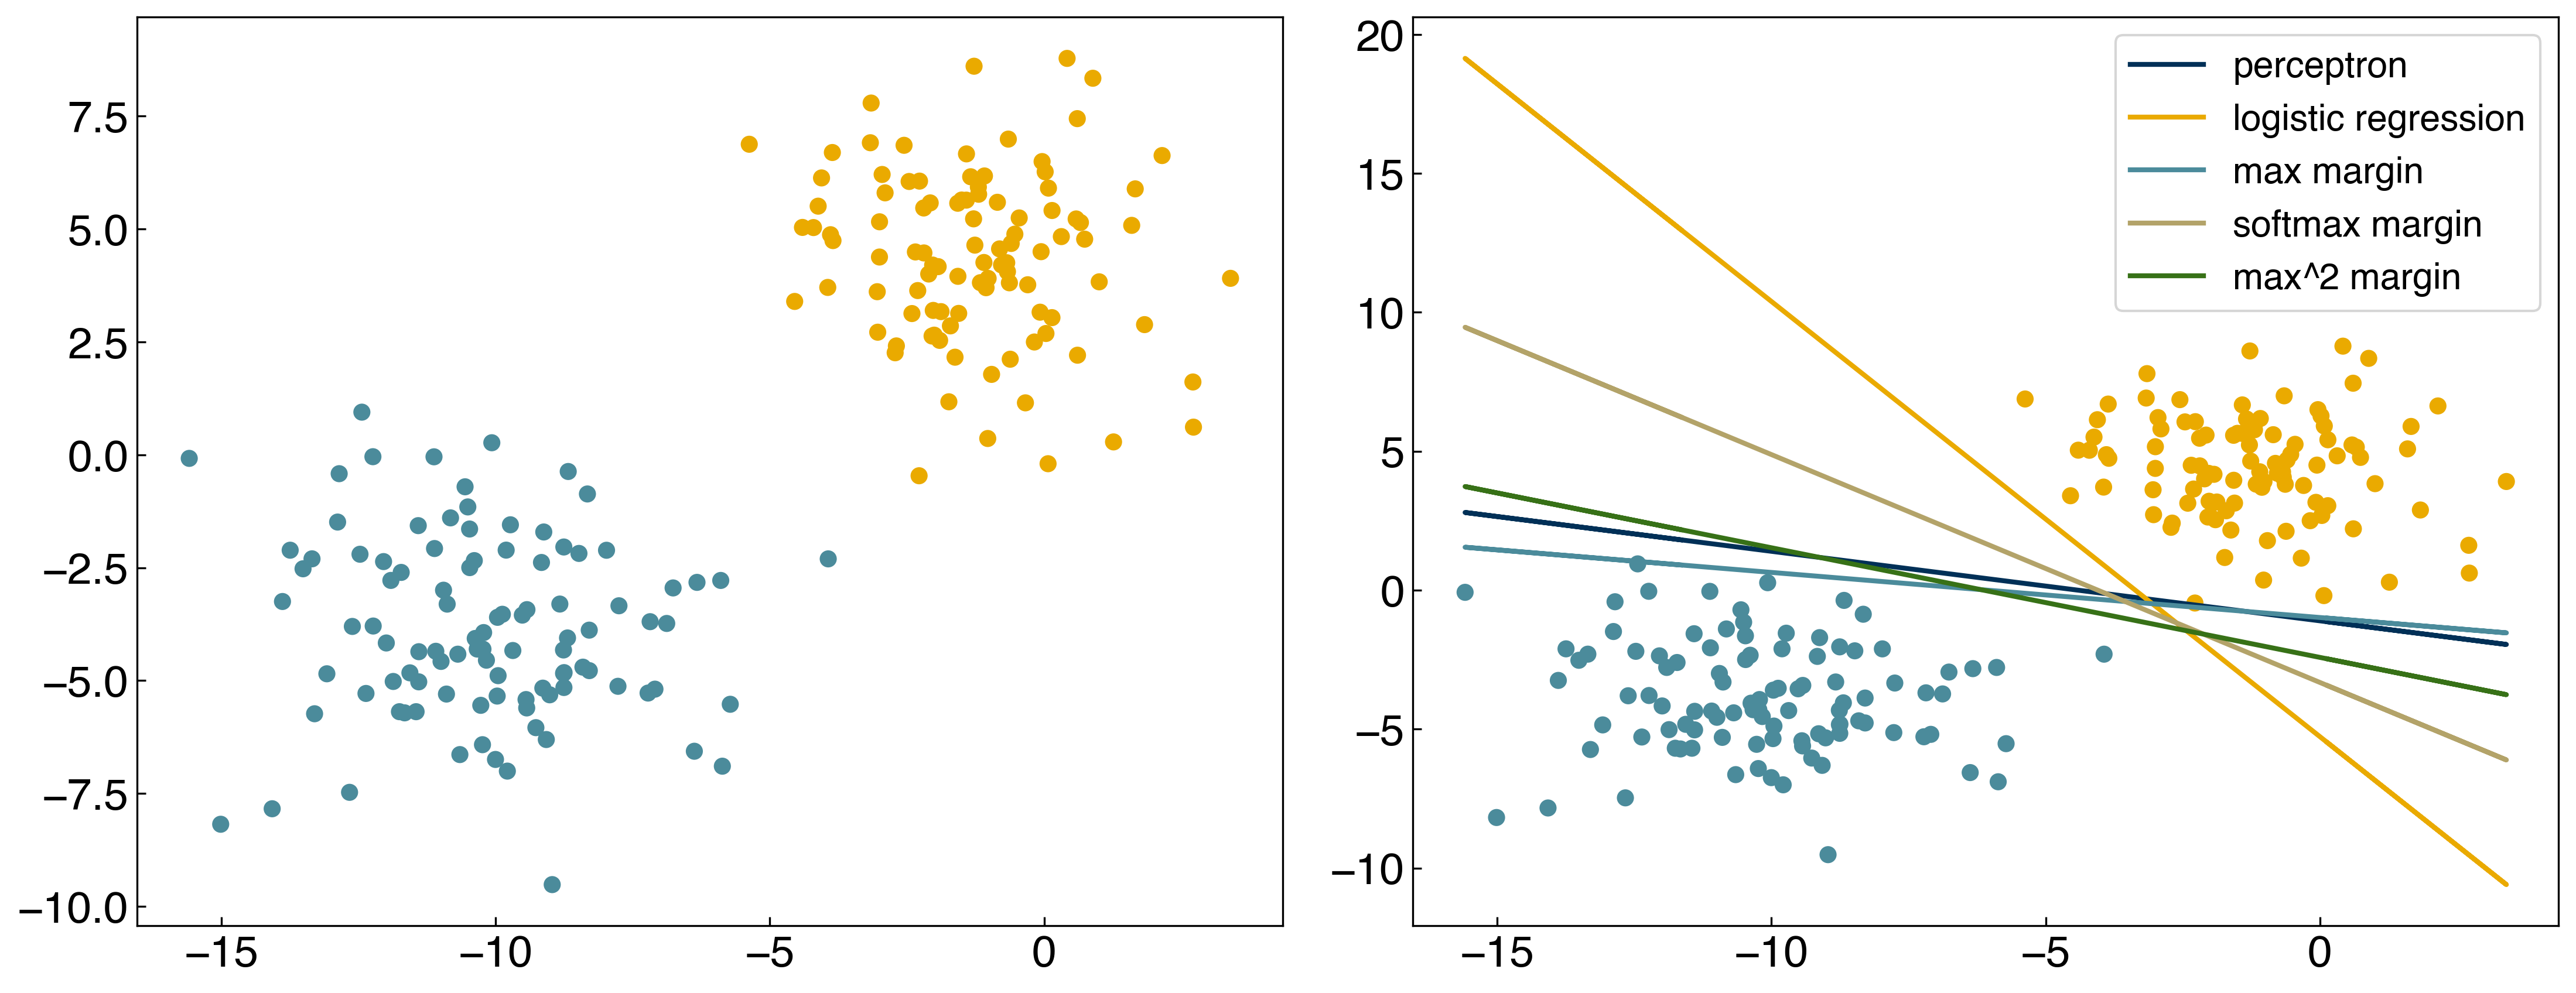

In [18]:
result = minimize(margin_cost_squared, w)
w_opt_margin2 = result.x

result = minimize(margin_cost_softmax, w)
w_opt_softmax = result.x

prediction = linear_classifier(X, w_opt_softmax)
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot lines
def plot_line(ax, color, w, X, label):
    m = -w[1] / w[2]
    b = -w[0] / w[2]
    ax.plot(X[:, 0], m*X[:, 0] + b, ls = '-', color = color, label = label)
    
labels = ['perceptron', 'logistic regression', 'max margin', 'softmax margin', 'max^2 margin']
w_set = [w_perceptron, w_logit,w_opt_margin, w_opt_margin2, w_opt_softmax]

for w_i, color, label in zip(w_set, clrs[:5], labels):
    plot_line(axes[1], color, w_i, X, label)
    
axes[1].legend();

### Discussion: Which of these models is the best?

> It's hard to tell in this case, but I would choose the softmax margin model.

There are infinitely many lines that have equal cost for a linearly-separable dataset. The line that you find will depend on the approximation used, and can also depend on the initial guesses for the parameter $\vec{w}$. As we will see, additional constraints can be added to the loss function to alleviate this issue.

## Support Vector Machine

### From margins to support vectors

One of the most powerful classification models, "support vector machines", are very closely related to the margin cost function:

$\bar{\bar{X}}\vec{w} \geq 1$ if $y_i=1$ (class 1)

$\bar{\bar{X}}\vec{w} \leq -1$ if $y_i=-1$ (class 2)

Multiply by $y$ and convert to an equality:

$max(0, 1 -y_i \bar{\bar{X}}\vec{w}) = 0$

and sum over all points to get the loss function: 

$g_{margin}(\vec{w}) = \sum_i max(0, 1-y_i \bar{\bar{X}}\vec{w})$

We can visualize this geometrically as:

<center>
<img src="images/margin_cost.png" width="500">
</center>

The distance between the discrimination line and the closest points is called the "margin" of the model, and the points that define the margin are called the "support vectors". It can be shown with geometric arguments that the width of the margins is inversely proportional to the size of the weight vector (without the intercept term):

<center>
<img src="images/margin_size.png" width="500">
</center>

For support vector machines, the goal is to maximize the margins between the "support vectors". This is achieved by minimizing the value of the weights, $\vec{w}$. This can be done by "regularization", as we discussed in the regression lectures. Specifically, support vector machines use $L_2$ regularization:

$g_{SVM}(\vec{w}) = \sum_i max(0, 1-y_i \bar{\bar{X}}\vec{w}) + \alpha ||\vec{\tilde{w}}||_2 $

where $\vec{\tilde{w}}$ are the weights with the intercept omitted.

Let's use the new regularized cost function:

In [19]:
X = X_blob
y = y_blob * 2 - 1

def regularized_cost(w, X = X, y = y, alpha = 1):
    X_intercept = add_intercept(X)
    Xb = np.dot(X_intercept, w)
    cost = sum(np.maximum(0, 1 - y*Xb))
    cost += alpha*np.linalg.norm(w[1:], 2)
    return cost

and optimize it with the minimize function:

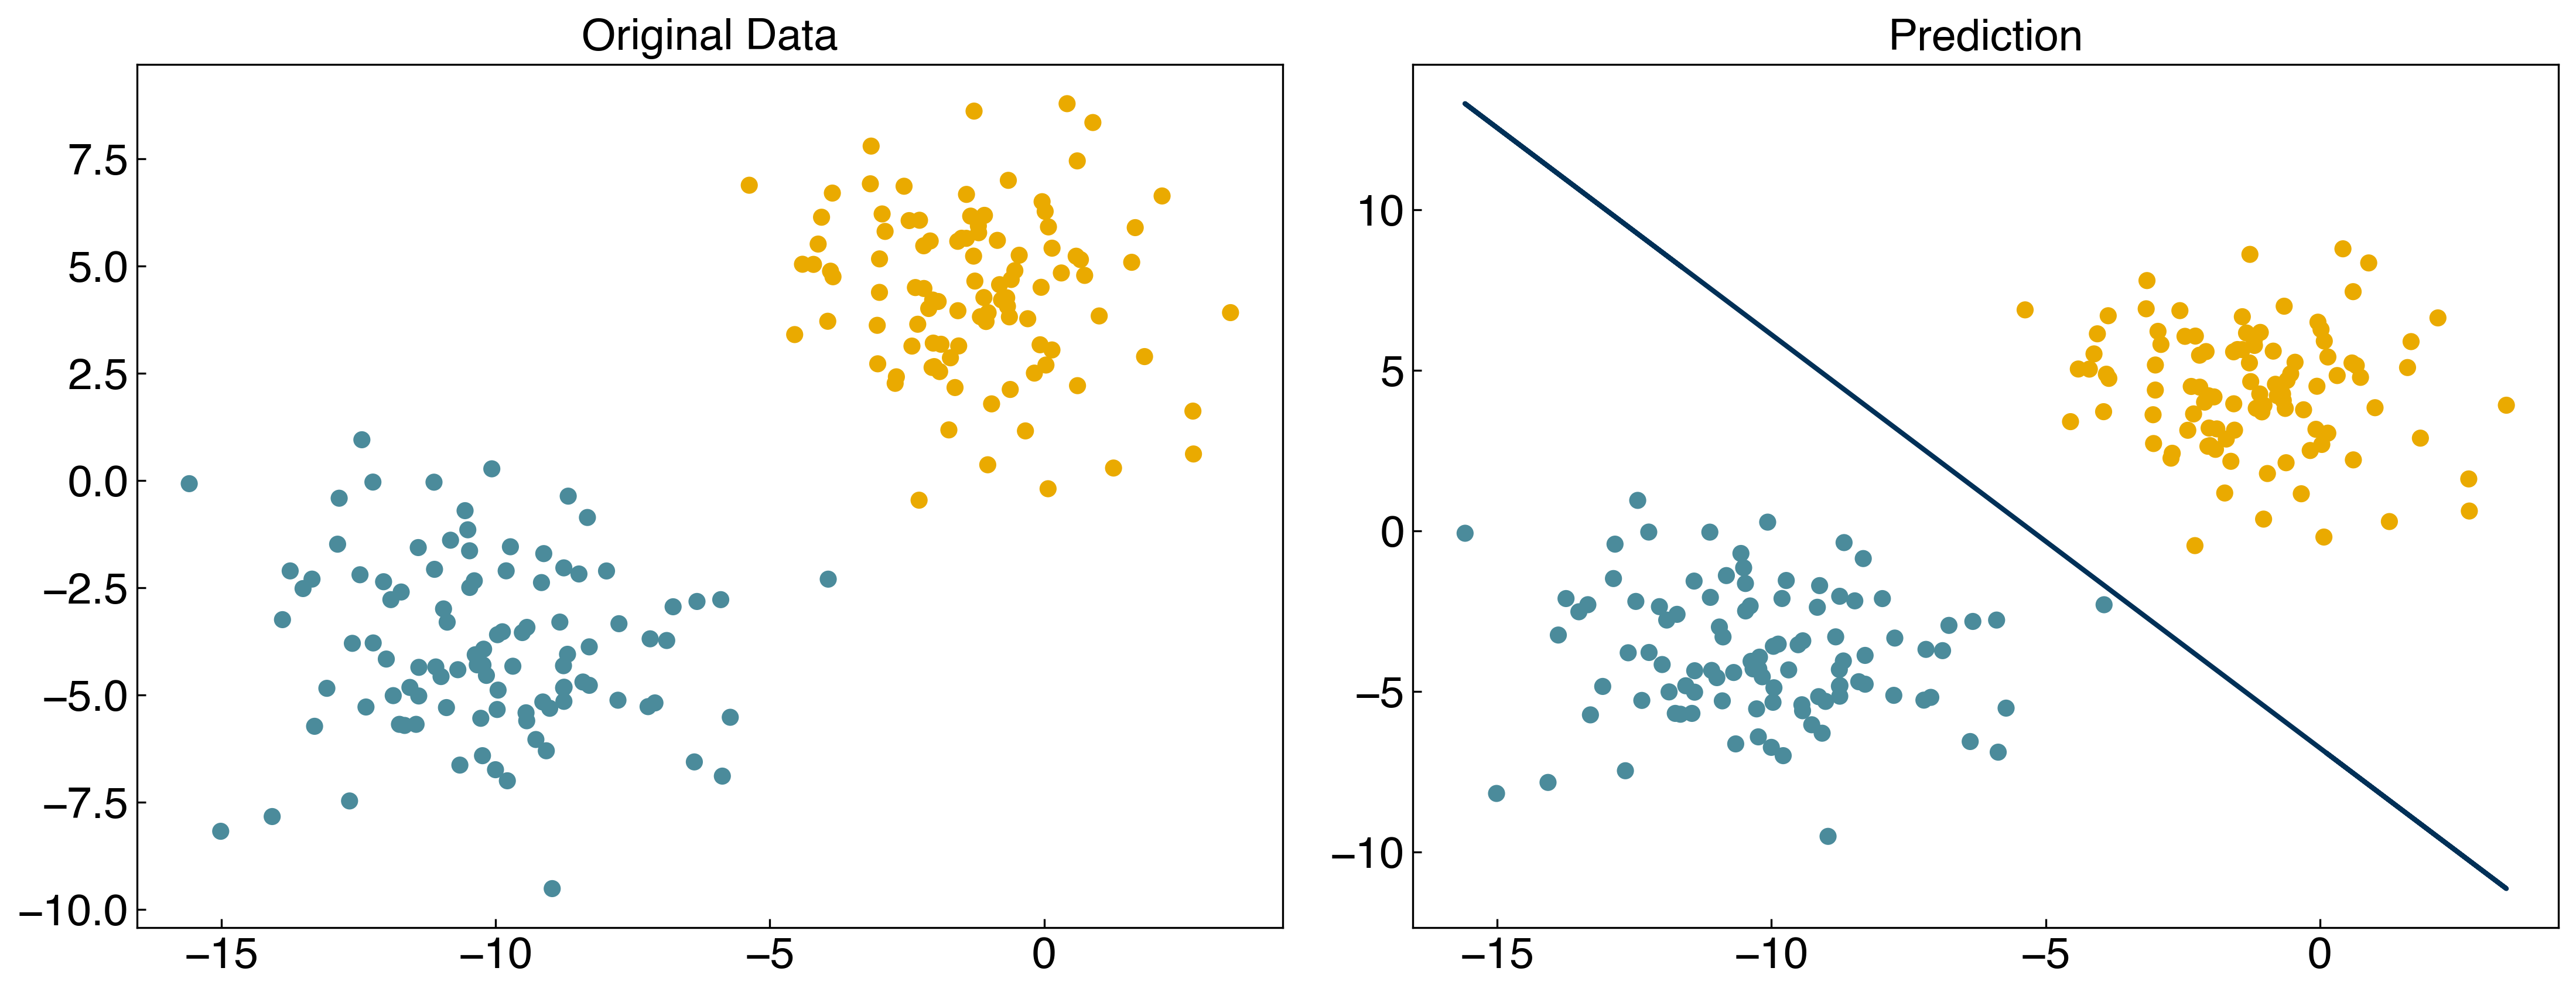

In [20]:
from scipy.optimize import minimize

w_guess = np.array([-10, -4, -10])
result = minimize(regularized_cost, w_guess, args = (X, y, 1))
w_svm = result.x

prediction = linear_classifier(X, w_svm)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_blob + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w_svm[1] / w_svm[2]
b = -w_svm[0] / w_svm[2]
axes[1].plot(X[:, 0], m*X[:, 0] + b, ls = '-')
axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

### Exercise: Plot the discrimination line for $\alpha$ = [0, 1, 2, 10, 100].

![image](./images/discriminationLine.png)

Support vector machines may sound scary, but as you can see above they are really just a very minor modification to ridge regression (least-squares regression regularized by the $L_2$ norm:

(1) The loss function is the "margin" loss function instead of the sum of squares.

(2) The model must be solved numerically because it is non-linear.

### Non-linearity and Kernels

We have seen lots of ways to find discrimination lines for linearly separable datasets, but they do not work well for non-linearly separable datasets:

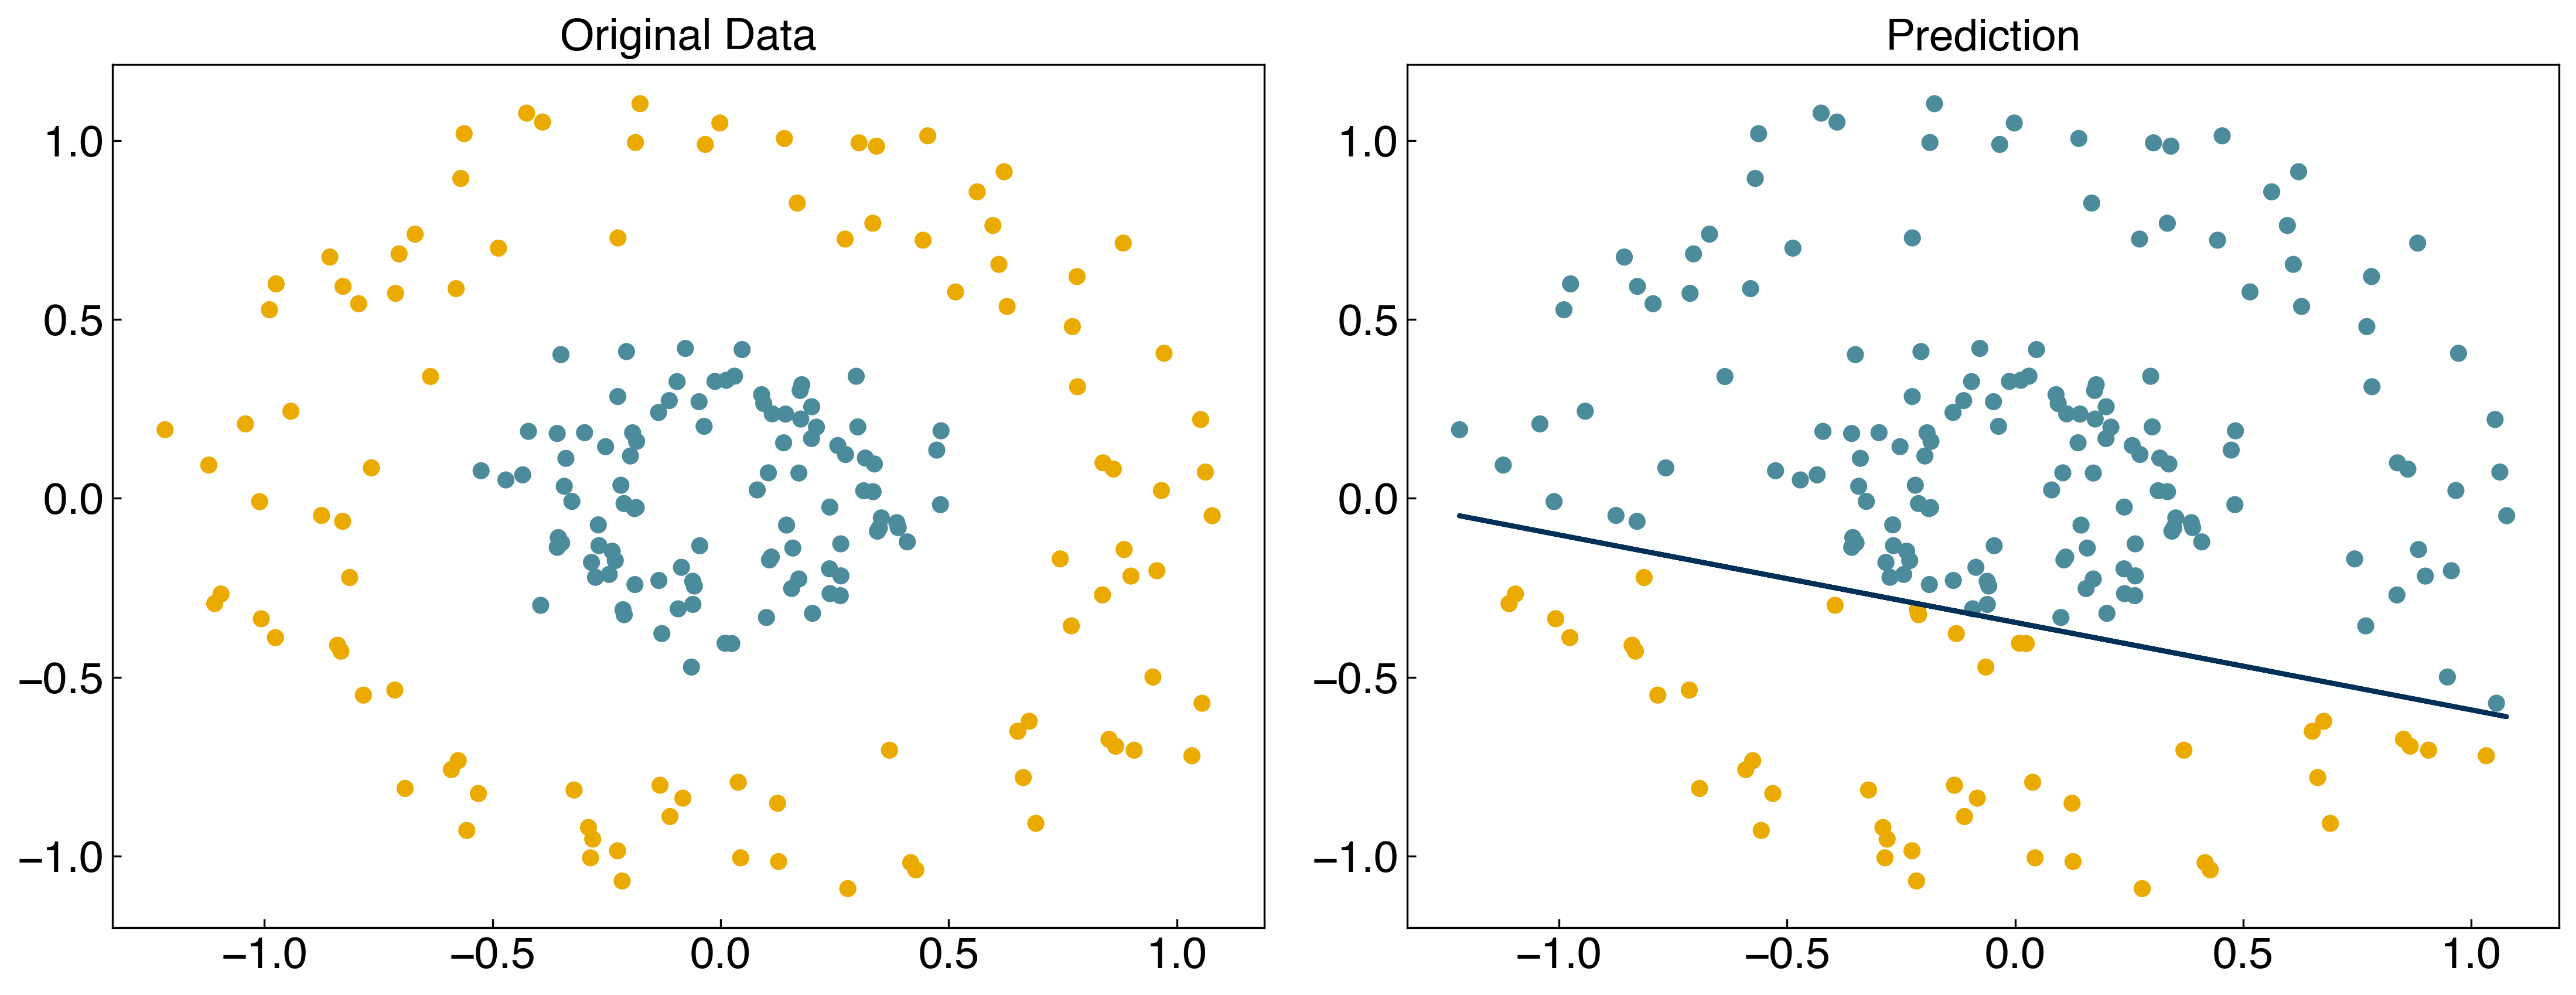

In [21]:
X = X_circles
y = y_circles*2 - 1

w_guess = np.array([-10, -4, -10])
result = minimize(regularized_cost, w_guess, args=(X, y, 1))
w_svm = result.x

prediction = linear_classifier(X, w_svm)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y_circles + 1])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[prediction + 1])

#plot line
m = -w_svm[1] / w_svm[2]
b = -w_svm[0] / w_svm[2]
axes[1].plot(X[:, 0], m*X[:,0]+b, ls = '-')
axes[0].set_title('Original Data')
axes[1].set_title('Prediction');

For the case of general linear regression, we saw that we could endow a model with non-linear behavior by transforming the input features using polynomials, Gaussians, or other non-linear transforms. We can do something similar here, but it is slightly trickier since there are two variables. We can use a Gaussian transform as before:

$x_{nonlinear} = exp(-(x_0^2 + x_1^2))$

where we have arbitrarily set the standard deviation to 1. We can add this as a third feature:

In [22]:
X_new = np.exp(-(X[:,0]**2 + X[:,1]**2))
X_new = X_new.reshape(-1, 1)
X_nonlinear = np.append(X, X_new, 1)
print(X_nonlinear.shape)

(200, 3)


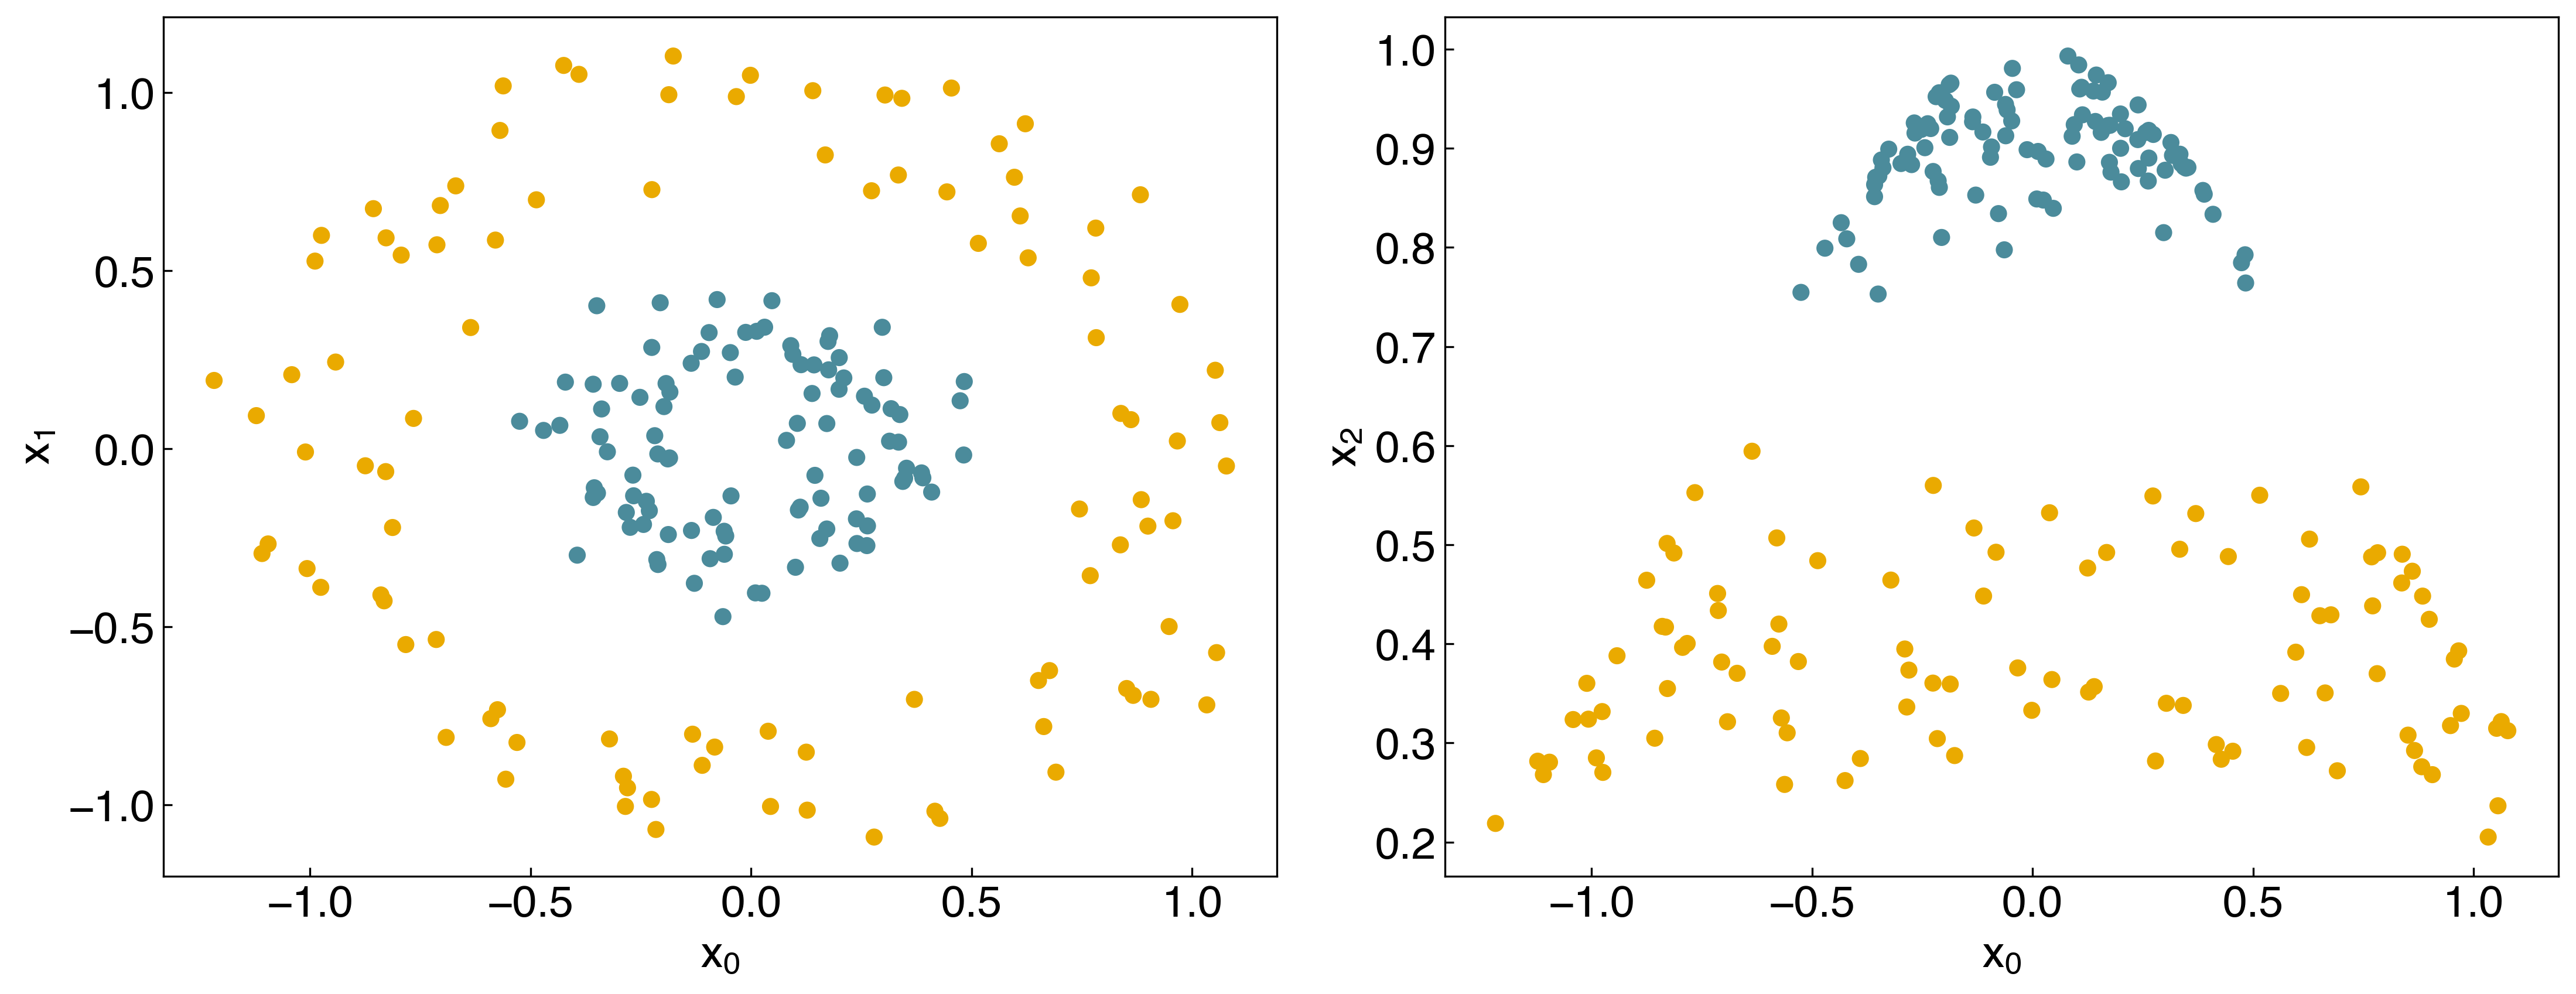

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_nonlinear[:, 0],X_nonlinear[:, 1],c = clrs[y_circles + 1])
axes[0].set_xlabel('$x_0$')
axes[0].set_ylabel('$x_1$')
axes[1].scatter(X_nonlinear[:, 0],X_nonlinear[:, 2],c = clrs[y_circles + 1])
axes[1].set_xlabel('$x_0$')
axes[1].set_ylabel('$x_2$');

We see that the dataset is now linearly separable in this transformed space!

Let's see what happens if we use this new matrix as input to the SVM:

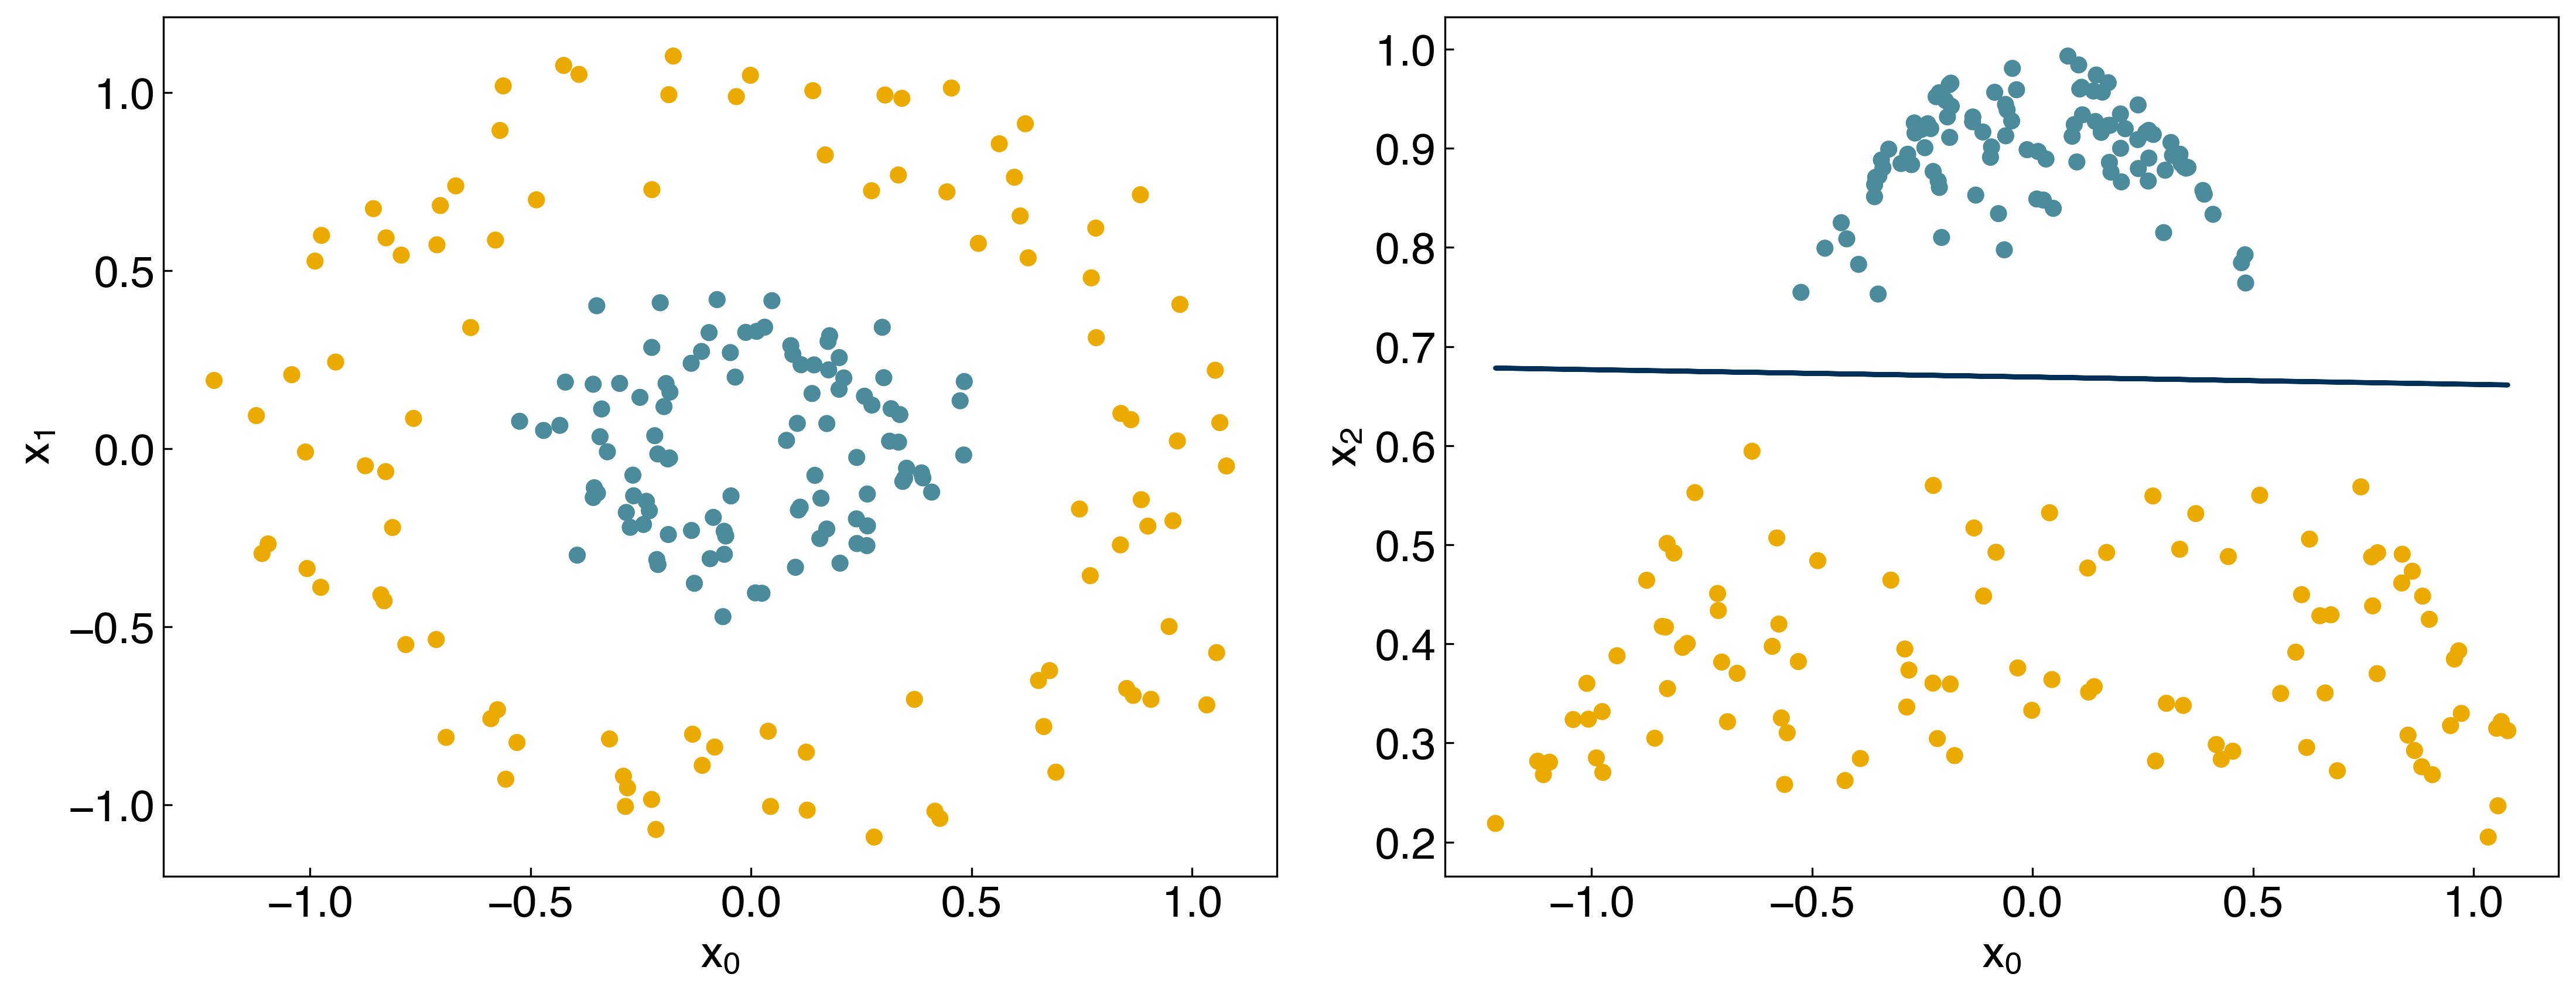

In [24]:
w_guess = np.array([-10, -4, 0, -10]) #note that we have an extra parameter now

result = minimize(regularized_cost, w_guess, args = (X_nonlinear, y, 1))
w_svm = result.x

prediction = linear_classifier(X_nonlinear, w_svm)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c = clrs[y_circles + 1])
axes[1].scatter(X_nonlinear[:, 0], X_nonlinear[:, 2], c = clrs[prediction + 1])

#plot line
m = -w_svm[1] / w_svm[3]
b = -w_svm[0] / w_svm[3]
axes[1].plot(X[:, 0], m*X[:,0] + b, ls = '-')
axes[0].set_xlabel('$x_0$')
axes[0].set_ylabel('$x_1$')
axes[1].set_xlabel('$x_0$')
axes[1].set_ylabel('$x_2$');

Now the model is able to correctly classify the non-linearly separable dataset! The kernel has created a new, higher-dimensional transformed space:

<center>
<img src="images/kernel_schematic.png" width="400">
</center>

Let's see how it works for the "moons" dataset:

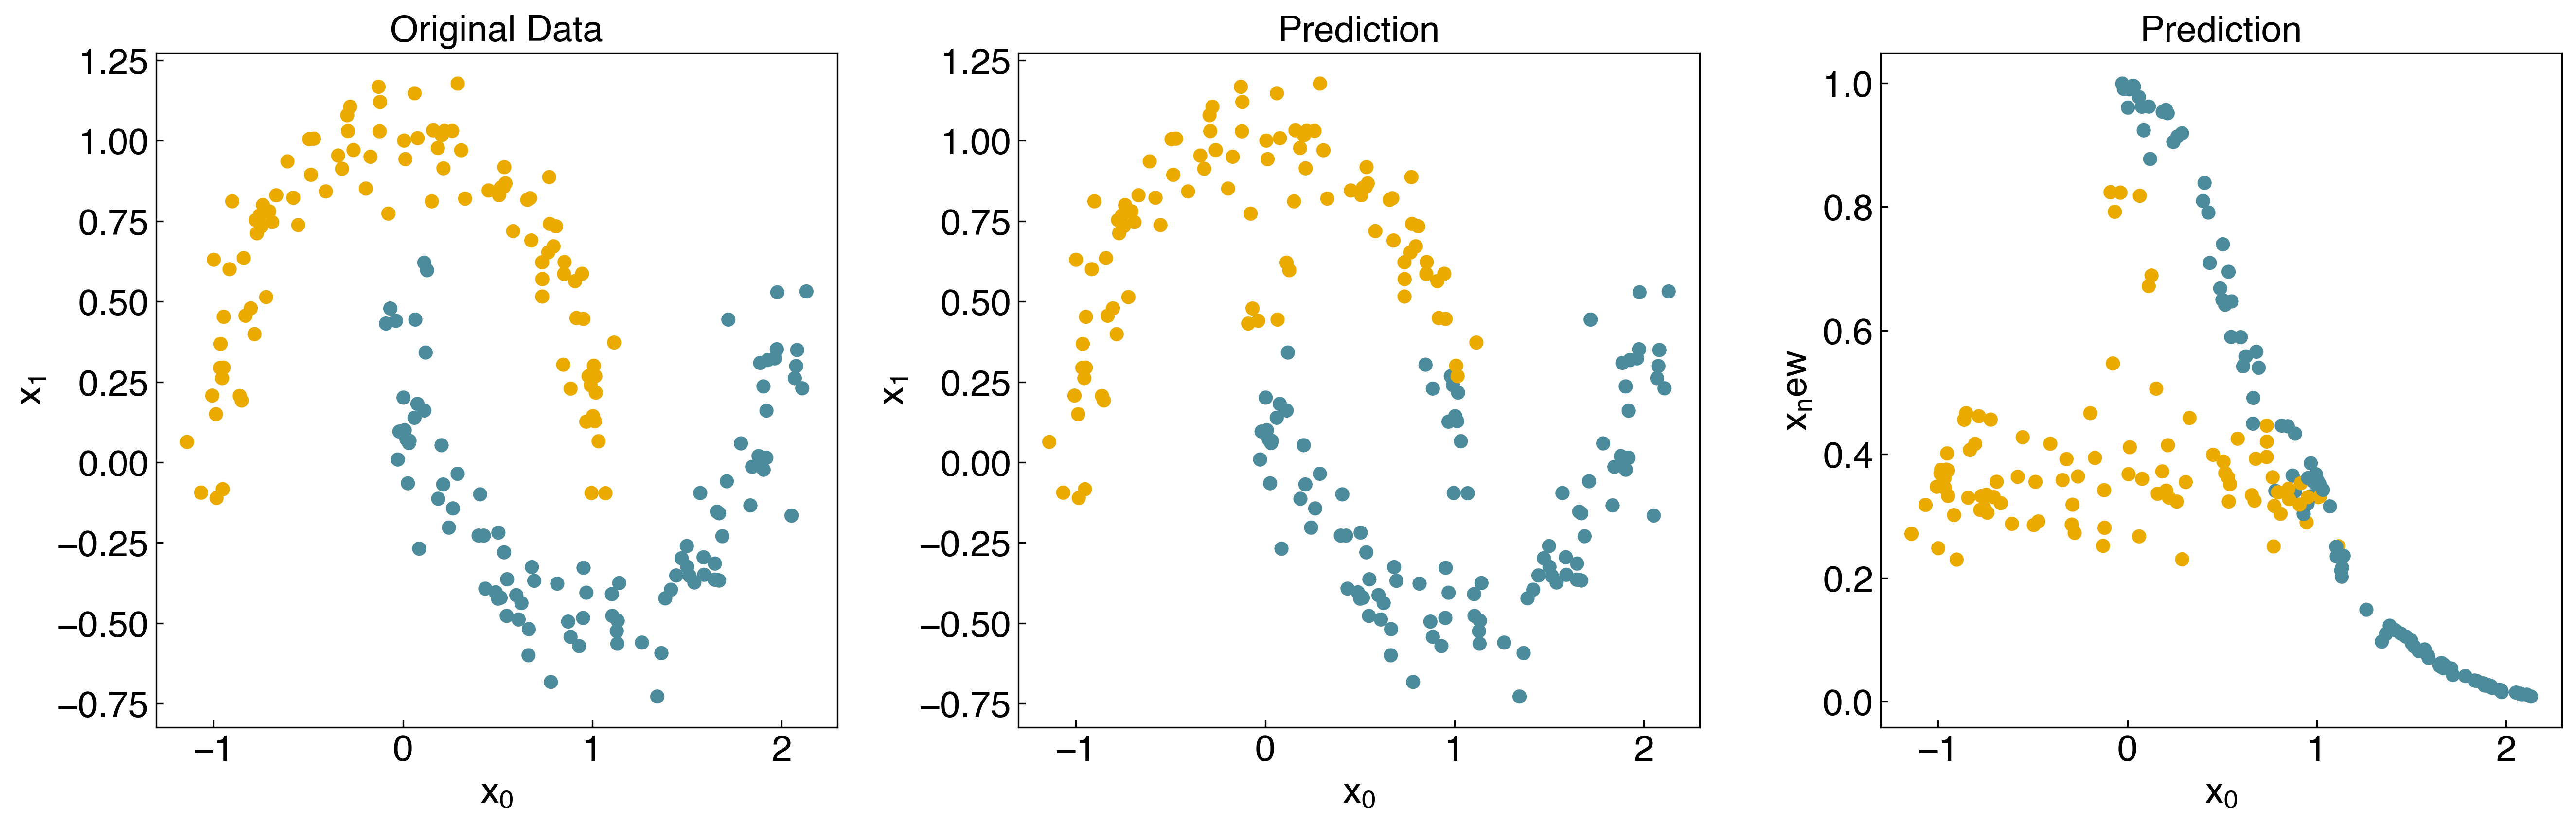

In [25]:
X = X_moons
y = y_moons*2 - 1

X_new = np.exp(-(X[:, 0]**2 + X[:, 1]**2))
X_new = X_new.reshape(-1, 1)
X_nonlinear = np.append(X, X_new, 1)

result = minimize(regularized_cost, w_guess, args = (X_nonlinear, y, 1))
w_svm = result.x

prediction = linear_classifier(X_nonlinear, w_svm)

fig, axes = plt.subplots(1, 3, figsize = (18, 6))
axes[0].scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c = clrs[y_moons + 1])
axes[1].scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c = clrs[prediction + 1])
axes[2].scatter(X_nonlinear[:, 0], X_nonlinear[:, 2], c = clrs[prediction + 1])

axes[0].set_xlabel('$x_0$')
axes[0].set_ylabel('$x_1$')
axes[0].set_title('Original Data')

axes[1].set_xlabel('$x_0$')
axes[1].set_ylabel('$x_1$')
axes[1].set_title('Prediction')

axes[2].set_xlabel('$x_0$')
axes[2].set_ylabel('$x_new$')
axes[2].set_title('Prediction');

We see that it is an improvement, but not perfect, because the data is not linearly separable in the transformed space. To make this more general can use the "kernel" idea from "kernel ridge regression", and construct a new "kernel matrix":

In [26]:
from sklearn.metrics.pairwise import rbf_kernel

X_kernel = rbf_kernel(X, X, gamma=1)
print(X_kernel.shape)

(200, 200)


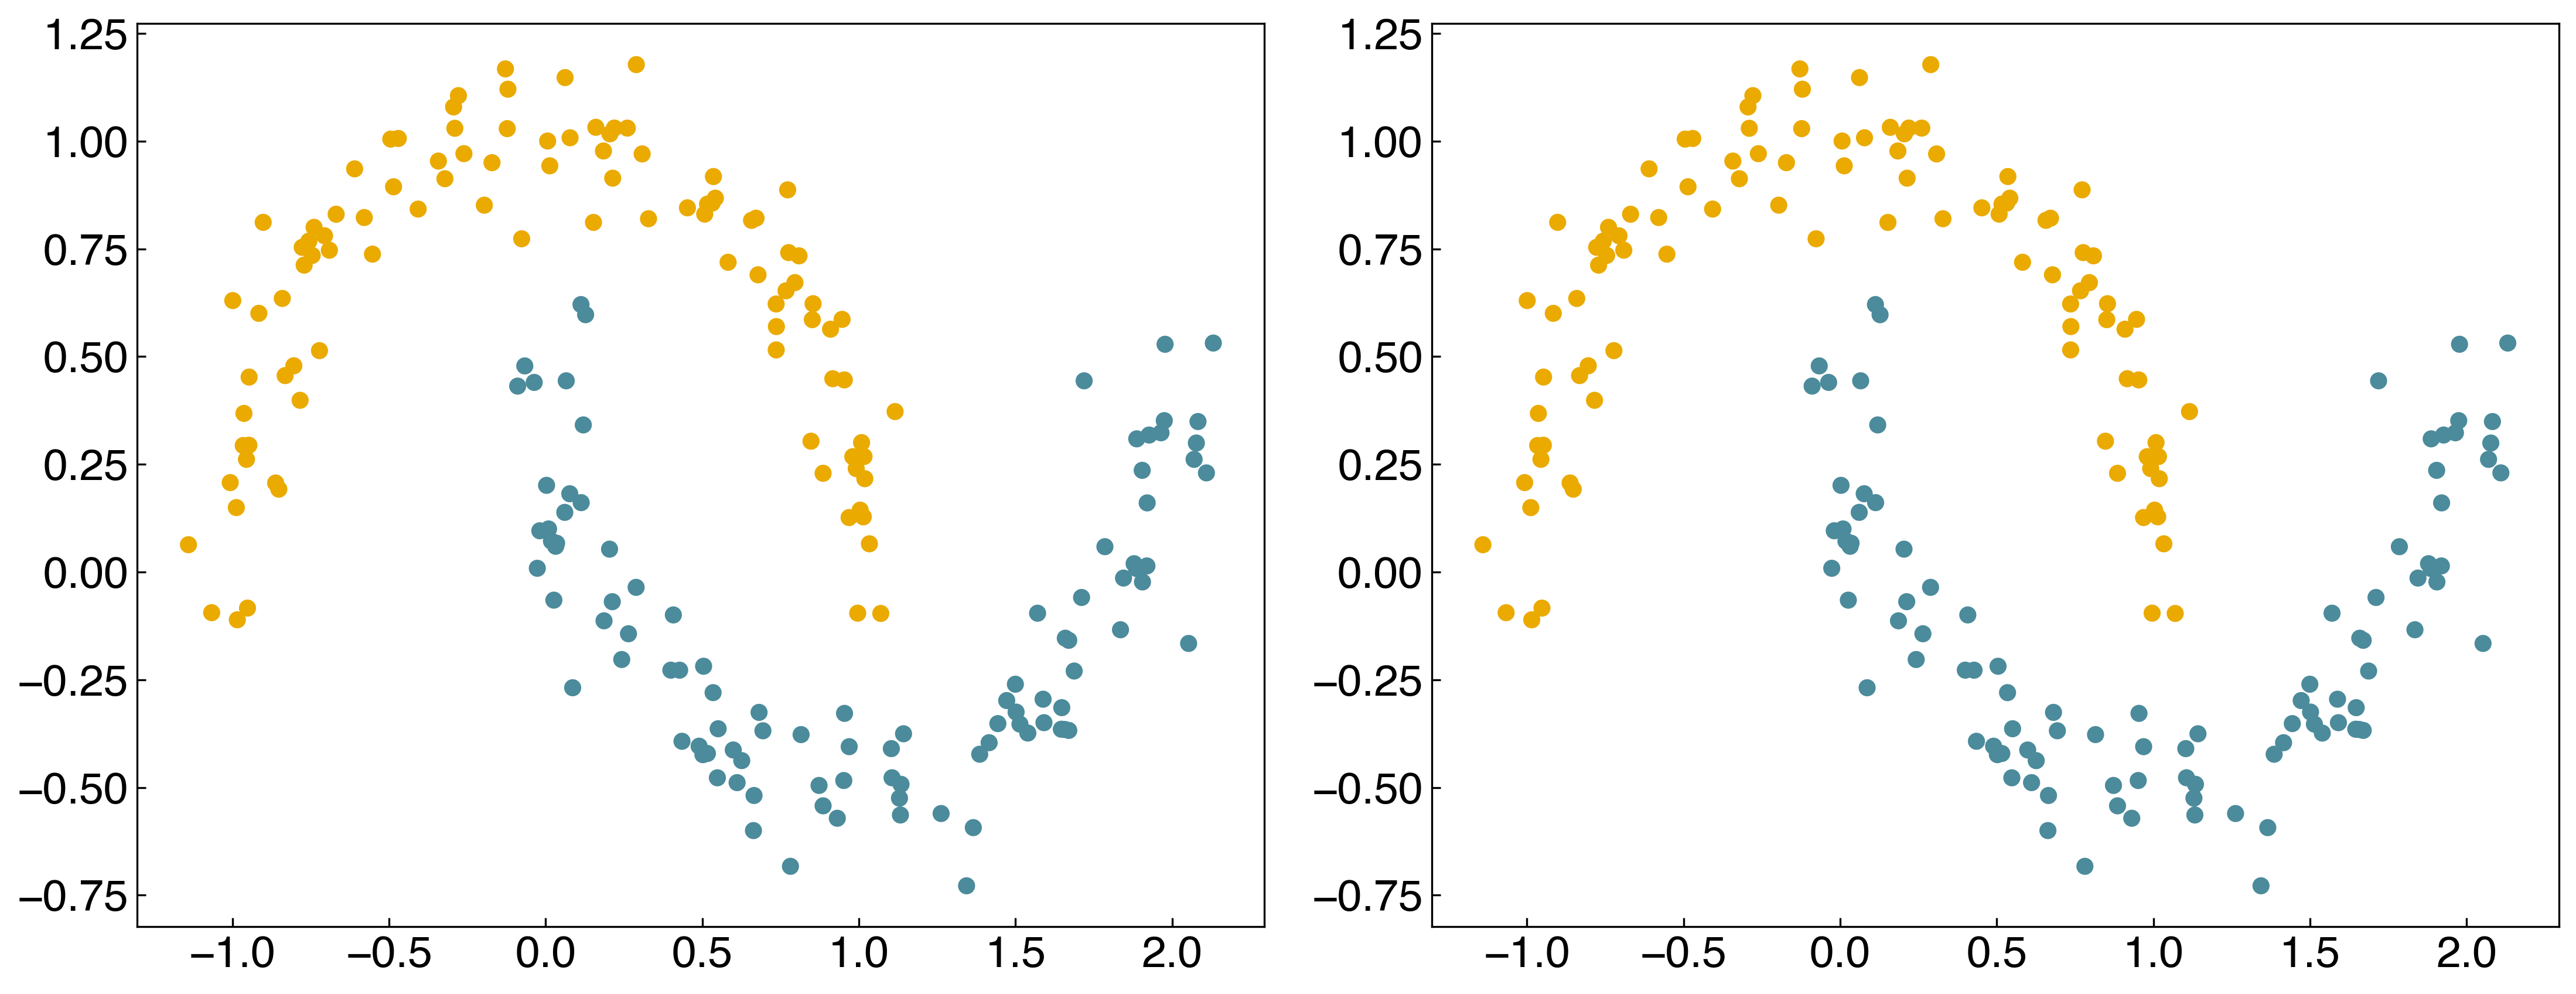

In [27]:
w_guess = np.zeros(X.shape[0] + 1)

result = minimize(regularized_cost, w_guess, args=(X_kernel, y, 1))
w_svm = result.x

prediction = linear_classifier(X_kernel, w_svm)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c = clrs[y_moons + 1])
axes[1].scatter(X_nonlinear[:, 0], X_nonlinear[:, 1], c = clrs[prediction + 1]);

### Discussion: Is this a parametric or non-parametric model? Do you think it will generalize?

> It is a non-parametric model. Since the RBF kernel matrix takes account of distances between data points, the number of parameters will increase as the data gets bigger. In this case, we have used all of the data to train the model, meaning the number of parameters is equal to the number of data points, and the model is over-fitted. Therefore, it is unlikely to generalize unless we use regularization or cross-validation.

We can make this process easier and add regularization by using the SVM model from `scikit-learn` (note that it is called a support vector "classifier", or SVC). The kernel width is controlled by `gamma`, and the regularization strength is controlled by `C`:

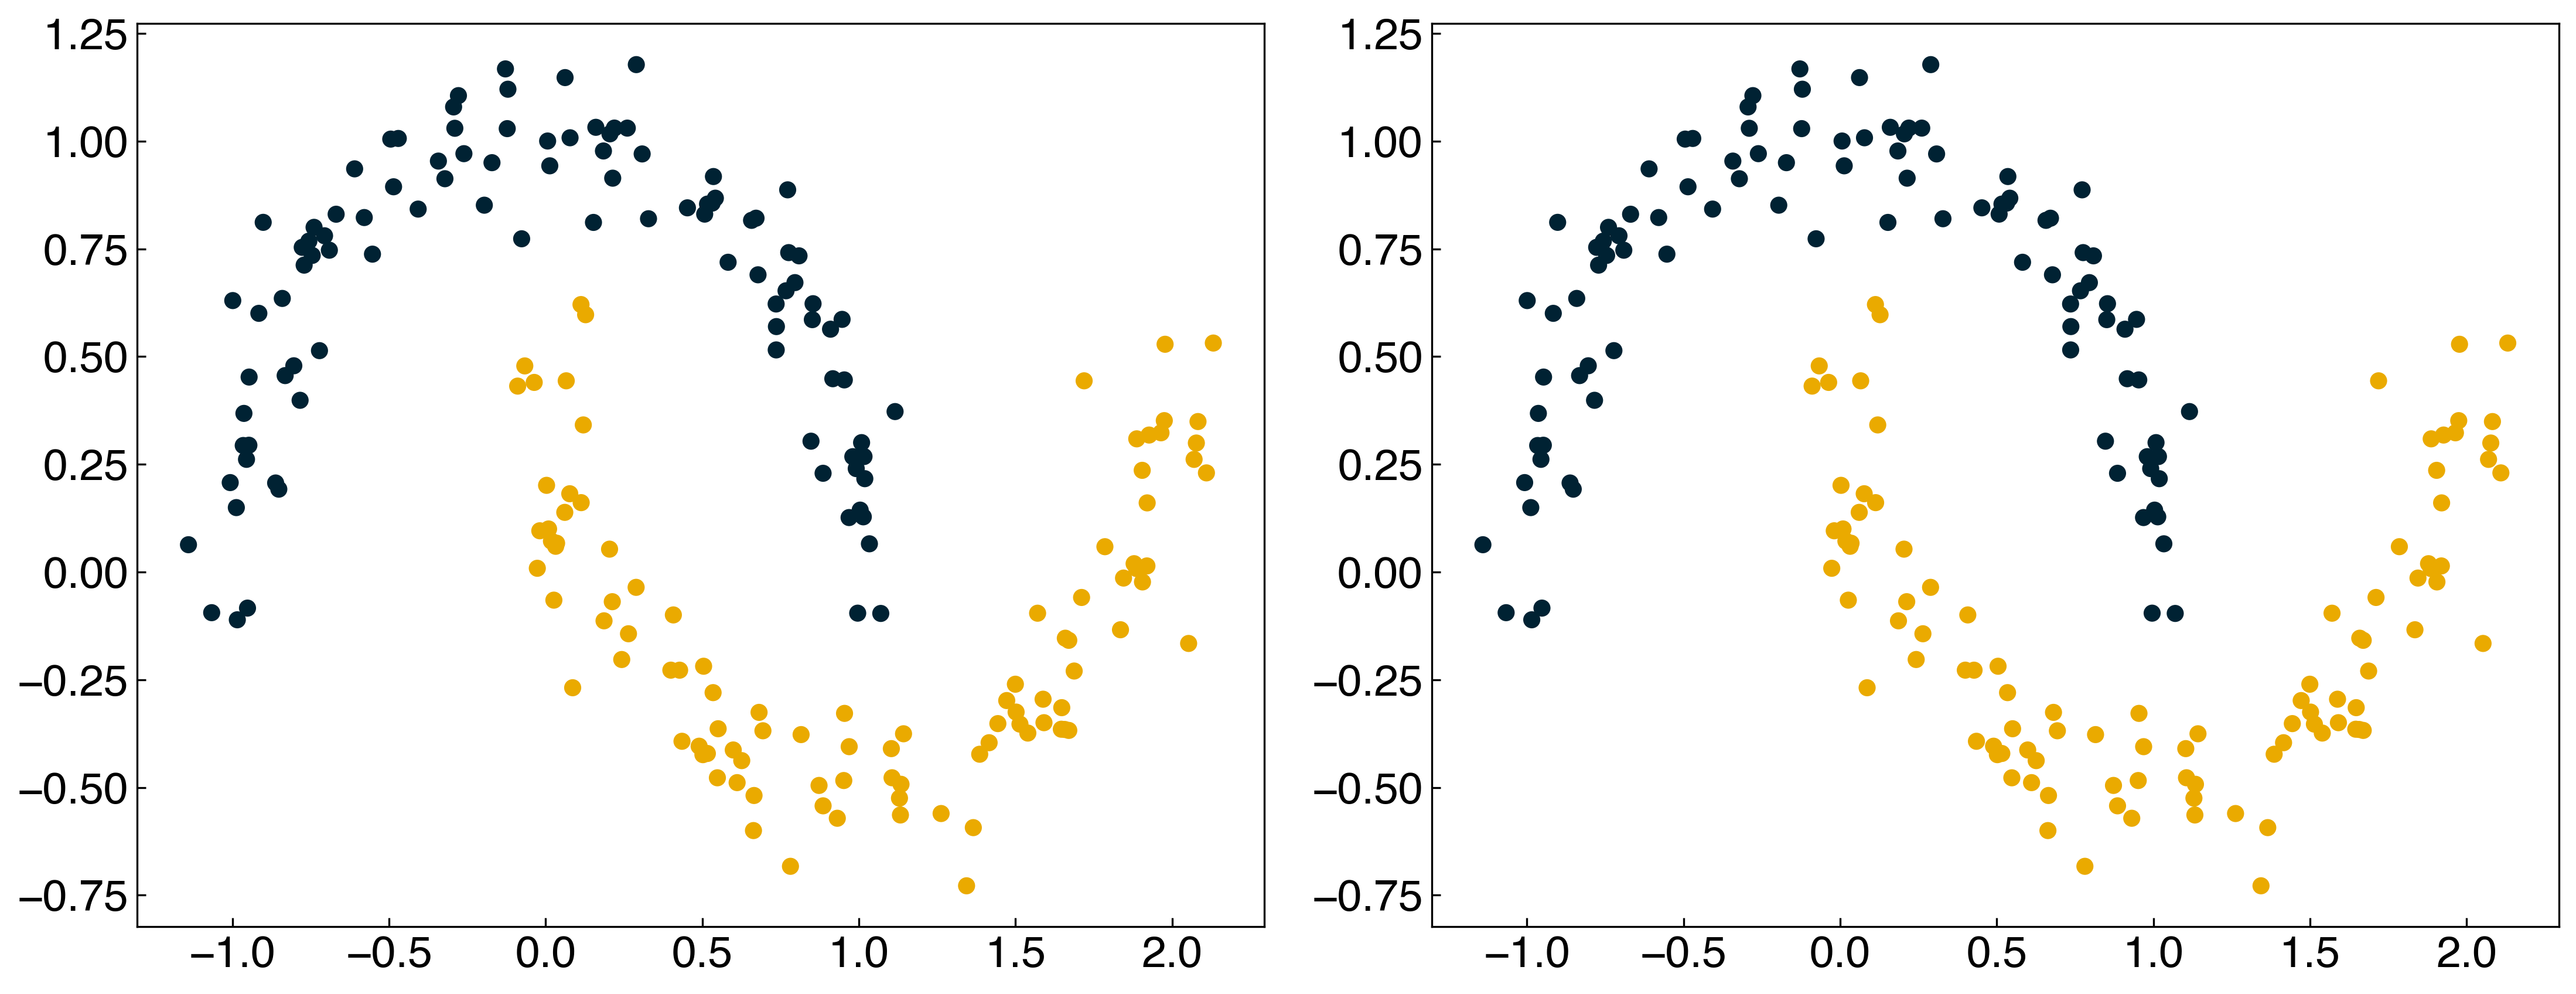

In [28]:
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel = 'rbf', gamma = 1, C = 1000)
model.fit(X, y)
y_predict = model.predict(X)

fig, axes = plt.subplots(1, 2, figsize = (15, 6))
axes[0].scatter(X[:, 0], X[:, 1], c = clrs[y])
axes[1].scatter(X[:, 0], X[:, 1], c = clrs[y_predict]);

Note that there is a slight difference between the regularization strength in the SVC model and ridge regression. In the SVC model, the parameter `C` is **inversely** proportional to the regularization strength:

$g_{SVM}(\vec{w}) = \sum_i max(0, 1-y_i \bar{\bar{X}}\vec{w}) + \frac{1}{C} ||\vec{\tilde{w}}||_2 $

The function below will allow visualization of the decision boundary. You don't need to understand how it works, but should understand its output.

In [29]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors = 'k',
               levels=[-1, 0, 1], alpha = 0.5,
               linestyles=['--', '-', '--'])
    if plot_support:
        # plot support vectors
        ax.scatter(model.support_vectors_[:, 0],
               model.support_vectors_[:, 1],
               s = 300, linewidth = 1, facecolors = 'none', edgecolors = 'k');
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Let's use this function to see how the decision boundary and the support vectors change as a function of `C`:

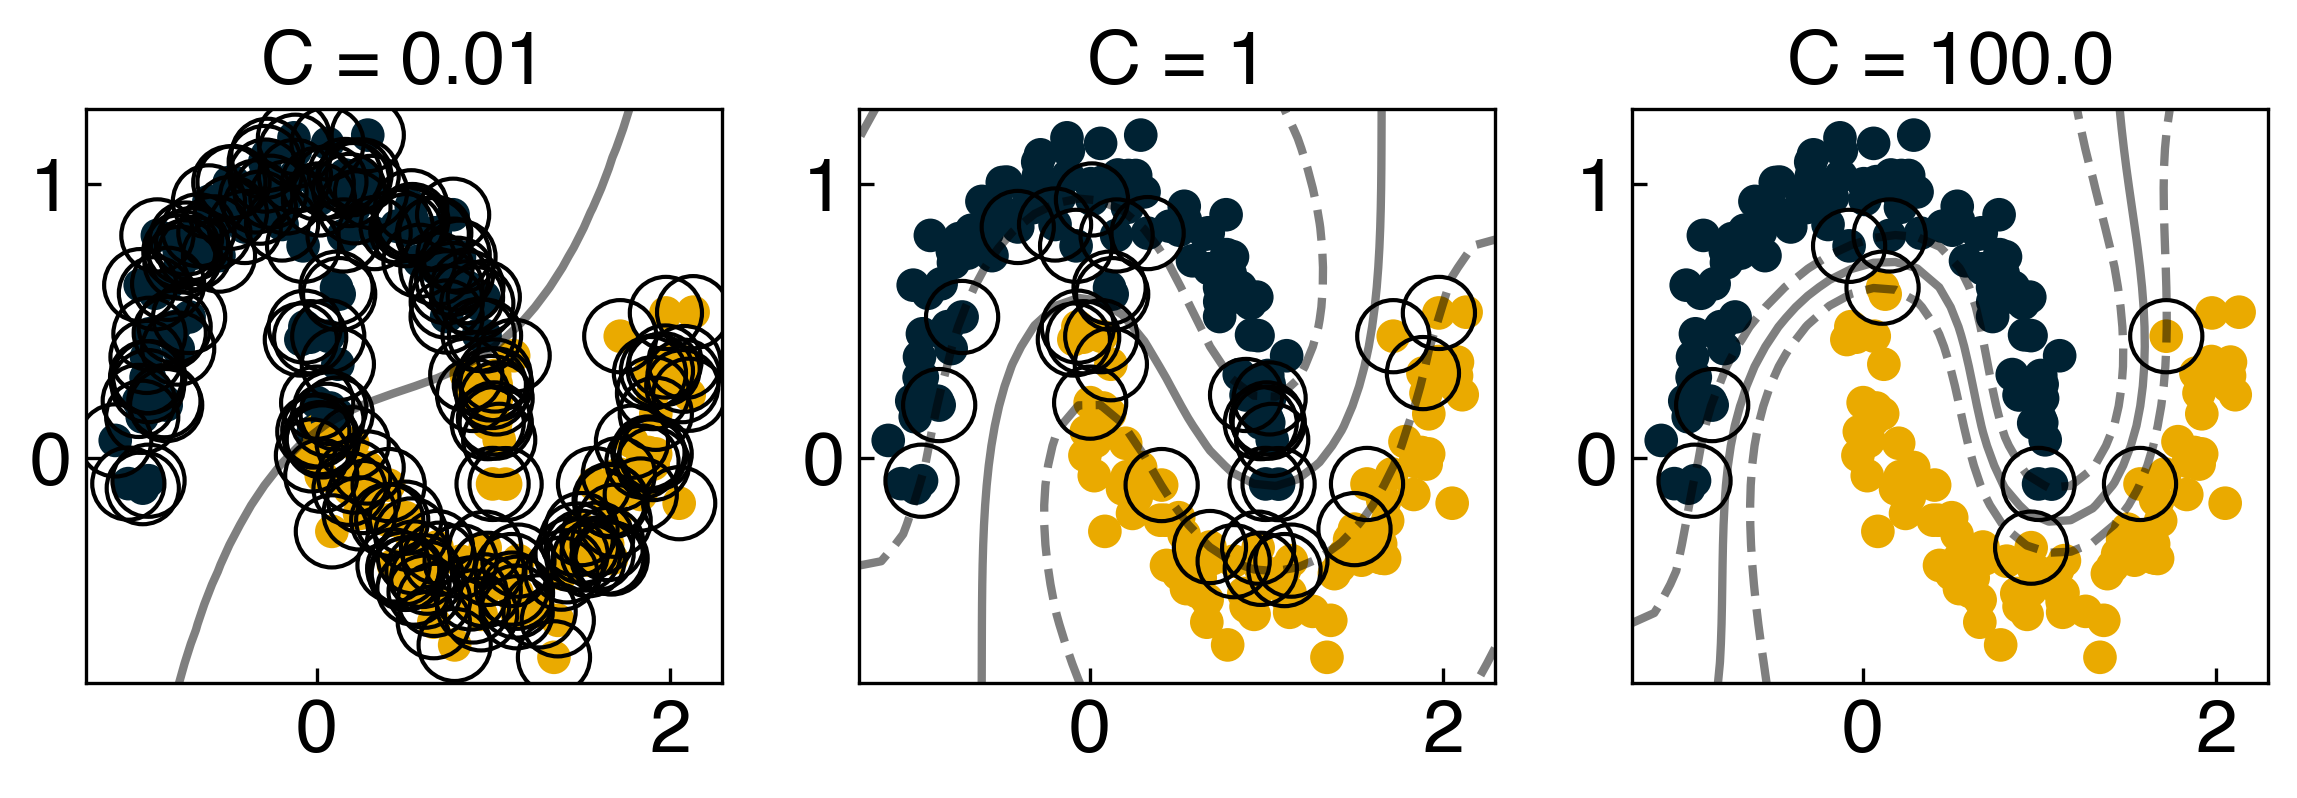

In [30]:
fig, axes = plt.subplots(1,3, figsize=(8,3))

Cs = [1e-2, 1, 1e2]

for i, Ci in enumerate(Cs):
    model = SVC(kernel = 'rbf', gamma = 1, C = Ci)
    model.fit(X, y)
    y_predict = model.predict(X)
    ax_i = axes[i]
    ax_i.scatter(X[:, 0], X[:, 1], c = clrs[y_predict], s = 50, cmap = 'RdBu')
    plot_svc_decision_function(model, ax = ax_i)
    ax_i.set_title('C = {}'.format(Ci))
    

### Discussion: How does the decision boundary change with $C$ and $\gamma$?

> As C goes to infinity, a small margin is accepted so the decision boundary will be very complex.  
The boundary will be complex as well if $\gamma$ goes to infinity. In this case, the boundaries will enclose just one data point. Look at the plots above and play with the values of `C` and `gamma` to get a better feel for how the boundary changes.

> Note that there are more "support vectors" as C gets smaller (or as alpha gets larger). This is because when there is more regularization, more points are allowed to be in the "margins".